In [1]:
## Optional, widen the notebook out to full width

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Load the data

In [2]:
web_df = pd.read_excel('data.xlsx', sheet_name='website data')

In [3]:
web_df.describe()

estimated wait time (mins)  number of visitors
count                10000.000000        10000.000000
mean                     4.958751           59.290900
std                      2.753532            7.599398
min                      0.569965           33.000000
25%                      3.063337           54.000000
50%                      4.350658           59.000000
75%                      6.120877           64.000000
max                     30.837486           94.000000

## Visualise and fit the distributions

<Figure size 1000x1200 with 0 Axes>

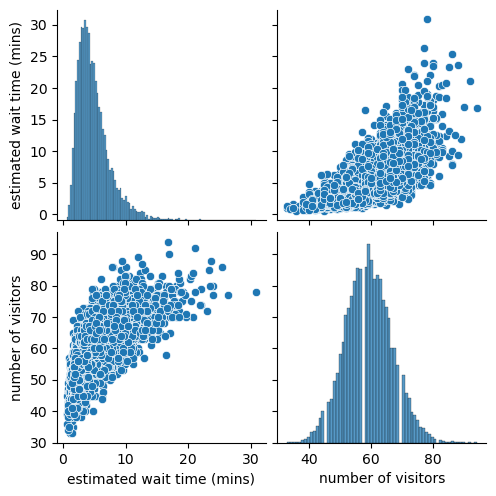

In [4]:
## Pair plot to visualise the distributions of estimated wait time (mins) and the number of visitors
## and how they could be correlated to one another.
plt.figure(figsize=(10, 12))
sns.pairplot(web_df);

- The distribution of estimated wait time resembles to that of a log-normal distribution or a gamma distribution 
- The distribution of number of visitors resembles to that of a normal distribution or a gamma distribution 
- Estimated wait time is clearly positively correlated to the number of visitors, though the relationship is not linear.

In [5]:
from scipy.stats import lognorm, gamma, norm

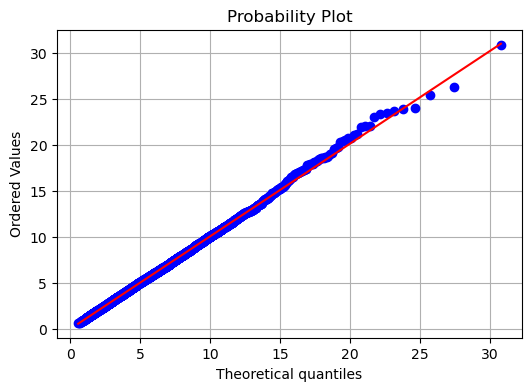


The goodness of fit for the lognormal distribution is 0.9997691138368482'

The best fit distribution of estimated wait time is a log-normal distribution with the 
shape parameter (sigma): 0.5107, 
loc (mu): -0.0649, 
scale: 4.4085



In [8]:
## Q–Qs plot to check how well the empirical quantiles of estimated wait time (mins)
## match the theoretical quantiles of the fitted log-normal distribution

est_wait = web_df['estimated wait time (mins)']
params_est_wait = lognorm.fit(est_wait)

fig = plt.figure(figsize=[6, 4])
fig, fit_est_wait = stats.probplot(
    est_wait, 
    dist='lognorm', 
    sparams=params_est_wait, 
    plot=plt,  
    fit=True,
)
plt.grid()
plt.show()

goodness_fit_est_wait = fit_est_wait[2]
print(f"""
The goodness of fit for the lognormal distribution is {goodness_fit_est_wait}'

The best fit distribution of estimated wait time is a log-normal distribution with the 
shape parameter (sigma): {round(params_est_wait[0], 4)}, 
loc (mu): {round(params_est_wait[1], 4)}, 
scale: {round(params_est_wait[2], 4)}
""")


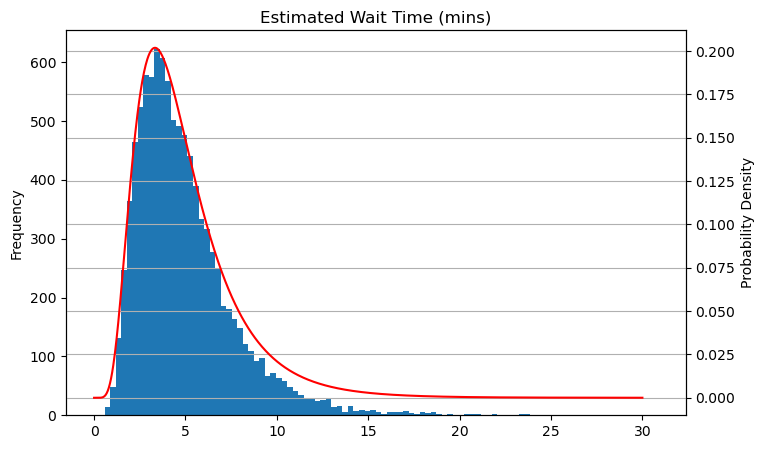

In [9]:
## Plot the distribution of the estimated wait time (mins) against the pdf of the fitted distribution 

log_normal_x = np.linspace(0, 30, num=1000)
log_normal_y = lognorm.pdf(
    log_normal_x, 
    s=params_est_wait[0], 
    loc=params_est_wait[1], 
    scale=params_est_wait[2]
)

ax = est_wait.plot.hist(
    figsize=(8, 5),
    bins=100,
)
ax2 = ax.twinx()
ax2.plot(log_normal_x, log_normal_y, color='r')
ax2.set_ylabel("Probability Density")
plt.grid()
plt.title('Estimated Wait Time (mins)')
plt.show()

For estimated wait time (mins), the best fit is the lognormal distribution shown above.

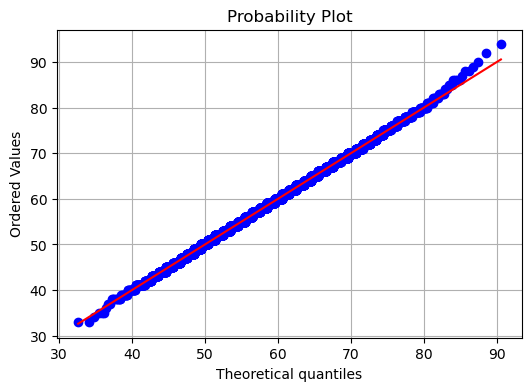


The goodness of fit for the Gamma distribution is 0.999181754631252'

The best fit distribution of number of visitors is a gamma distribution with the 
shape parameter (alpha): 223.157, 
loc: -54.217, 
scale (1/beta): 0.5086



In [10]:
## Q–Qs plot to check how well the empirical quantiles of number of visitors
## match the theoretical quantiles of the fitted gamma distribution

num_visitors = web_df['number of visitors']
num_visitors_params = gamma.fit(num_visitors)

fig = plt.figure(figsize=[6, 4])
fig, num_visitors_fit = stats.probplot(
    num_visitors, 
    dist='gamma', 
    sparams=num_visitors_params, 
    plot=plt,  
    fit=True
)
plt.grid()
plt.show()

num_visitors_goodness_fit = num_visitors_fit[2]
print(f"""
The goodness of fit for the Gamma distribution is {num_visitors_goodness_fit}'

The best fit distribution of number of visitors is a gamma distribution with the 
shape parameter (alpha): {round(num_visitors_params[0], 4)}, 
loc: {round(num_visitors_params[1], 4)}, 
scale (1/beta): {round(num_visitors_params[2], 4)}
""")

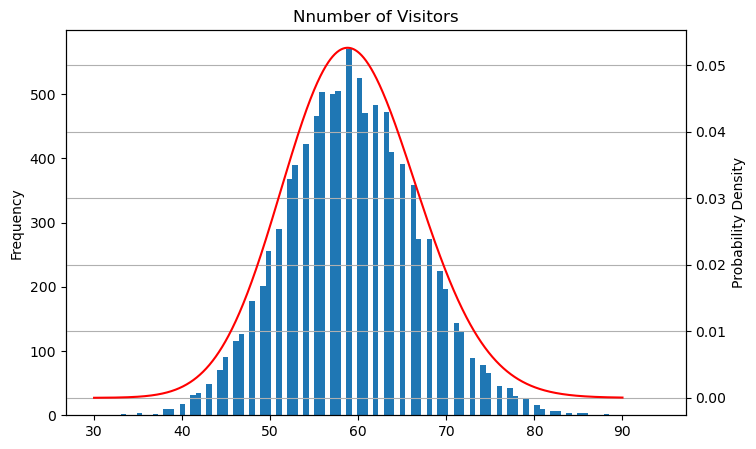

In [11]:
## Plot the distribution of the number of visitors (mins) against the pdf of the fitted distribution 

gamma_x = np.linspace(30, 90, num=1000)
gamma_y = gamma.pdf(
    gamma_x, 
    a=num_visitors_params[0], 
    loc=num_visitors_params[1], 
    scale=num_visitors_params[2]
)

ax = num_visitors.plot.hist(
    figsize=(8, 5),
    bins=100,
)
ax2 = ax.twinx()
ax2.plot(gamma_x, gamma_y, color='r')
ax2.set_ylabel("Probability Density")
plt.title('Nnumber of Visitors')
plt.grid()
plt.show()

In [12]:
## Calculate the probability that the estimated wait time is greater than 10 minutes using 
## the cdf of the fitted lognormal distribution 
p1 = 1 - lognorm.cdf(
    10, 
    s=params_est_wait[0], 
    loc=params_est_wait[1], 
    scale=params_est_wait[2]
)

print(f"The probability that the estimated wait time is greater than 10 minutes is {round(p1, 4)}")

The probability that the estimated wait time is greater than 10 minutes is 0.053


In [13]:
## Calculate the probability that the number of visitors is less than 46 using the cdf of 
## the fitted gamma distribution
p2 = gamma.cdf(
    46, 
    a=num_visitors_params[0], 
    loc=num_visitors_params[1], 
    scale=num_visitors_params[2]
)

print(f"The probability that the number of visitors is less than 46 is {round(p2, 4)}")

The probability that the number of visitors is less than 46 is 0.0359


## Modelling the relationship between the distributions

- The objective here is to apply some non-linear transformation to the two variables so that there is a linear relationship between the distributions of the transformed variables.
- The first target distribution which sprang to mind is normal distributions. Because a lognormal distribution and a gamma distribution can easily be transformed into a normal distribution by log and boxcox transformation respectively. In addition, any affine transformation of a normal distribution is still a normal distribution.

In [14]:
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox

In [15]:
## Assuming a linear relationship between the transformed distribution, the next step is to get find the lambda
## to be used in boxcox transformation which would give the best linear model measured by r2 score

## Grid search to find the best lambda
r2_scores = []
n_range = np.arange(0.1, 3, 0.01)
for n in n_range:
    # for each lambda, fit a linear model and record the r2 score
    lr = LinearRegression()
    X = pd.DataFrame(boxcox(num_visitors, n))
    y = np.log(est_wait)
    lr.fit(X, y)
    r2_scores.append(lr.score(X, y))
    
## Collate the r2 scores from the grid search into a dataframe
r2_score_df = pd.DataFrame(r2_scores, index=n_range, columns=['r^2'])

In [16]:
import copy
## Get the optimal lambda for boxcox transformation
optimal_transform = r2_score_df[(r2_score_df == r2_score_df.max()).values]
optimal_lmbda = optimal_transform.index[0]

## Transform the raw variables - estimated wait time (mins) and the number of visitors
op_x = (num_visitors**optimal_lmbda - 1) / optimal_lmbda
op_y = np.log(est_wait)

## Collate the transformed variables into a new dataframe
transformed_web_df = copy.deepcopy(web_df)
transformed_web_df['estimated wait time (mins)'] = op_y
transformed_web_df['number of visitors'] = op_x

In [22]:
## Fit a linear regressor with the optimal transformed variables
op_lr = LinearRegression()
op_lr.fit(
    transformed_web_df[['number of visitors']], 
    transformed_web_df['estimated wait time (mins)']
)

print(f"""
Optimal gradient: {round(op_lr.coef_[0], 4)}
Optimal intercept: {round(op_lr.intercept_, 4)}
""")


Optimal gradient: 0.3415
Optimal intercept: -3.4849



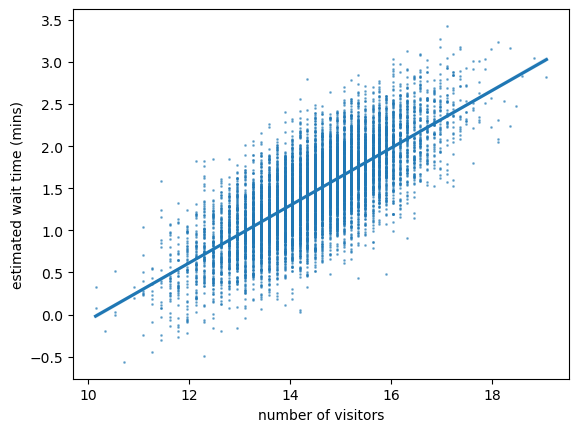

In [23]:
## Scatter plot with a regression line to demonstrate the validity of the assumed 
## linear relationship between two transformed variables
sns.regplot(
    x=transformed_web_df['number of visitors'], 
    y=transformed_web_df['estimated wait time (mins)'],
    scatter_kws={"alpha": 0.5, 's': 1},
)
plt.show()

Let $x$ be the number of visitors, $y$ be the estimated waiting time.

The transformed y can be expressed as: $Y = \log(y)$

The trasnformed x can be expressed as: $X = \frac{{x^\lambda - 1}}{{\lambda}}$, where $\lambda = 0.53$

And the relationship between $X$ and $Y$ can be expressed as: $Y = kX + b$, where $k = 0.341$ and $b = -3.485$
 
Thus the relationship between $x$ and $y$ is: $y = \exp(k\frac{{x^\lambda - 1}}{{\lambda}} + b)$

In [25]:
## Double check if Y is indeed an linear transformation of X

## fit a normal distribution to the transformed estimated wait time
est_wait_transformed = transformed_web_df['estimated wait time (mins)']
params_est_wait_transformed = norm.fit(est_wait_transformed)
op_y_mu, op_y_std = params_est_wait_transformed


## fit a normal distribution to the number of visitors
num_visitors_transformed = transformed_web_df['number of visitors']
params_num_visitors_transformed = norm.fit(num_visitors_transformed)
op_x_mu, op_x_std = params_num_visitors_transformed


## If the transformed is valid, we'd expected the the following numbers to
## be close to op_y_mu and op_y_std respectievly
op_y_mu_mapped = op_lr.coef_[0] * op_x_mu + op_lr.intercept_
op_y_std_mapped = op_lr.coef_[0] * op_x_std


print(f"""
The mean of transformed transformed estimated wait time: {round(op_y_mu, 4)}
The mean of transformed transformed number of visitors: {round(op_x_mu, 4)}
They roughly follow the relationship: op_y_mu = k * op_x_mu - b, 
because the linearly mapped mean is: {round(op_y_mu_mapped, 4)}


The std of transformed transformed estimated wait time: {round(op_y_std, 4)}
The std of transformed transformed number of visitors: {round(op_x_std, 4)}
The linearly mapped standard deviaition - {round(op_y_std_mapped, 4)} - does not match that of 
the real standard deviation of the transformed transformed number of visitors.
""")


The mean of transformed transformed estimated wait time: 1.4666
The mean of transformed transformed number of visitors: 14.5007
They roughly follow the relationship: op_y_mu = k * op_x_mu - b, 
because the linearly mapped mean is: 1.4666


The std of transformed transformed estimated wait time: 0.5195
The std of transformed transformed number of visitors: 1.1183
The linearly mapped standard deviaition - 0.3819 - does not match that of 
the real standard deviation of the transformed transformed number of visitors.



# Fit the joint distribution
The analysis above suggests that we should instead to fit the transformed variables to a bivariate normal distribution

In [26]:
from scipy.stats import multivariate_normal
multi_norm_mean = transformed_web_df.mean()
multi_norm_cov = transformed_web_df.cov()

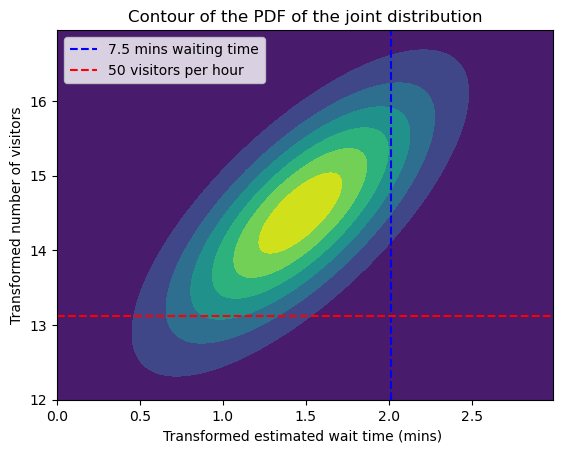

In [27]:
## Visualise the joint distribution

x, y = np.mgrid[
    0: 3: 0.01, 
    12: 17: 0.05
]

multi_norm_pdf = multivariate_normal.pdf(
    np.dstack((x, y)),
    mean=multi_norm_mean.values, 
    cov=multi_norm_cov.values
)

plt.contourf(x, y, multi_norm_pdf)
plt.axvline(
    x=np.log(7.5),
    color='b', 
    linestyle='--',
    label='7.5 mins waiting time',
)
plt.axhline(
    y=boxcox(50, optimal_lmbda), 
    color='r', 
    linestyle='--',
    label='50 visitors per hour'
)
plt.xlabel("Transformed estimated wait time (mins) ")
plt.ylabel("Transformed number of visitors")
plt.legend()
plt.title('Contour of the PDF of the joint distribution')
plt.show()

In [28]:
## Calculate the probability that when we have 50 or more visitors per hour, 
## they can expect to wait  more than 7.5 minutes to log on. 

p_0 = 1 + multivariate_normal.cdf(
    np.array([
        np.log(7.5), 
        boxcox(50, optimal_lmbda)
    ]), 
    mean=multi_norm_mean, 
    cov=multi_norm_cov
) - norm.cdf(
    boxcox(50, optimal_lmbda),
    loc=op_x_mu, 
    scale=op_x_std
) - norm.cdf(
    np.log(7.5),
    loc=op_y_mu, 
    scale=op_y_std
)

print(f"""
The probability of waiting more than 7.5 mins and having more than 50 visitors per hour is {round(p_0, 4)}
""")


p_1 = 1 - norm.cdf(
    boxcox(50, optimal_lmbda),
    loc=op_x_mu, 
    scale=op_x_std
)

print(f"""
The probability of having more than 50 visitors per hour is {round(p_1, 4)}
""")

p_2 = p_0 / p_1
print(f"""
Therefore, the probability of waiting more than 7.5 mins when there are more than 50 visitors per hour is {round(p_2, 4)}
""")


The probability of waiting more than 7.5 mins and having more than 50 visitors per hour is 0.1455


The probability of having more than 50 visitors per hour is 0.8921


Therefore, the probability of waiting more than 7.5 mins when there are more than 50 visitors per hour is 0.1631



# Q3.5: Genuine data vs synthetic data

## Load the data

In [29]:
tick_df = pd.read_excel('data.xlsx', sheet_name='tick data')

In [30]:
tick_df.describe()

Asset A       Asset B       Asset C       Asset D       Asset E  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean       0.000002     -0.000006     -0.000004     -0.000008     -0.000002   
std        0.000753      0.001145      0.000435      0.000962      0.000756   
min       -0.003097     -0.009408     -0.004414     -0.010227     -0.003104   
25%       -0.000512     -0.000585     -0.000219     -0.000494     -0.000506   
50%        0.000003      0.000000      0.000000     -0.000010     -0.000005   
75%        0.000506      0.000572      0.000203      0.000466      0.000503   
max        0.003007      0.013518      0.003892      0.007753      0.003255   

            Asset F       Asset G       Asset H       Asset I       Asset J  
count  25000.000000  25000.000000  2.500000e+04  2.500000e+04  25000.000000  
mean      -0.000005      0.000002 -4.240855e-09  4.610458e-06     -0.000006  
std        0.000531      0.000353  7.563298e-04  7.583868e-04      0.000748  
min       -0.017182     -0.002831 -2.883502e-03 -3.036240e-03     -0.003265  
25%       -0.000252     -0.000157 -5.176459e-04 -5.096295e-04     -0.000511  
50%        0.000000      0.000000  6.820408e-06  1.150025e-07     -0.000014  
75%        0.000236      0.000159  5.080406e-04  5.152843e-04      0.000501  
max        0.003743      0.003243  3.505634e-03  2.945087e-03      0.003349

## Exploratory data analysis

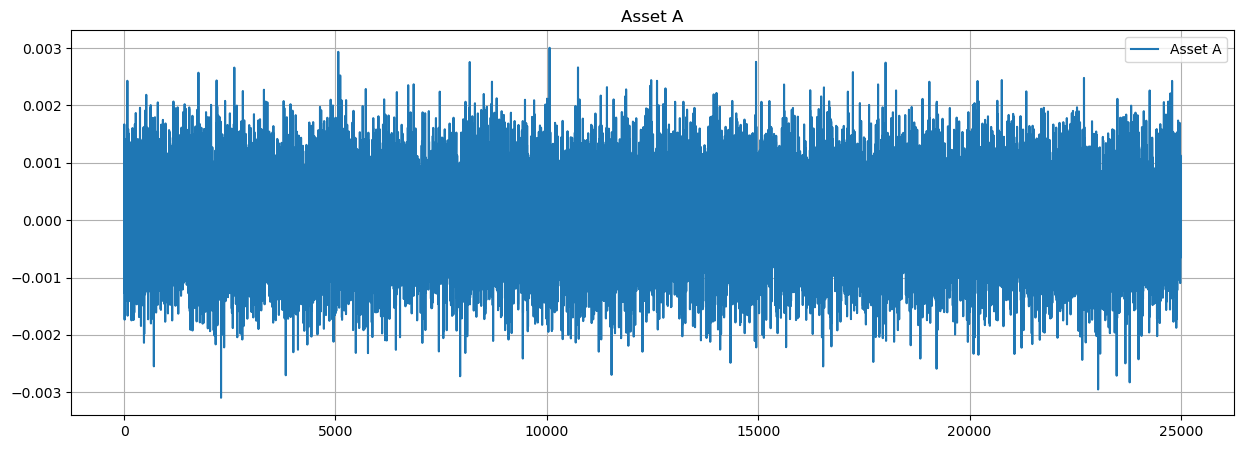

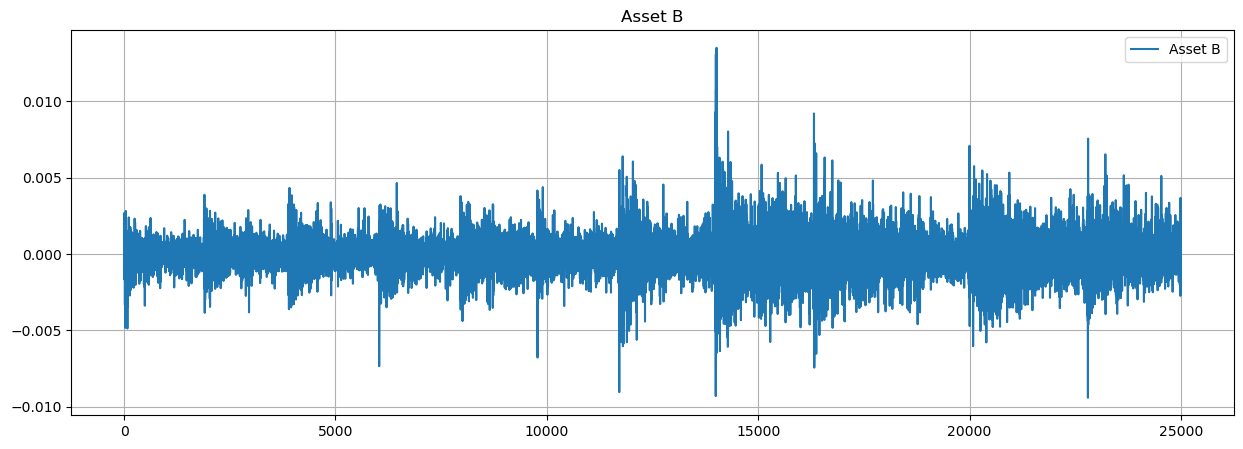

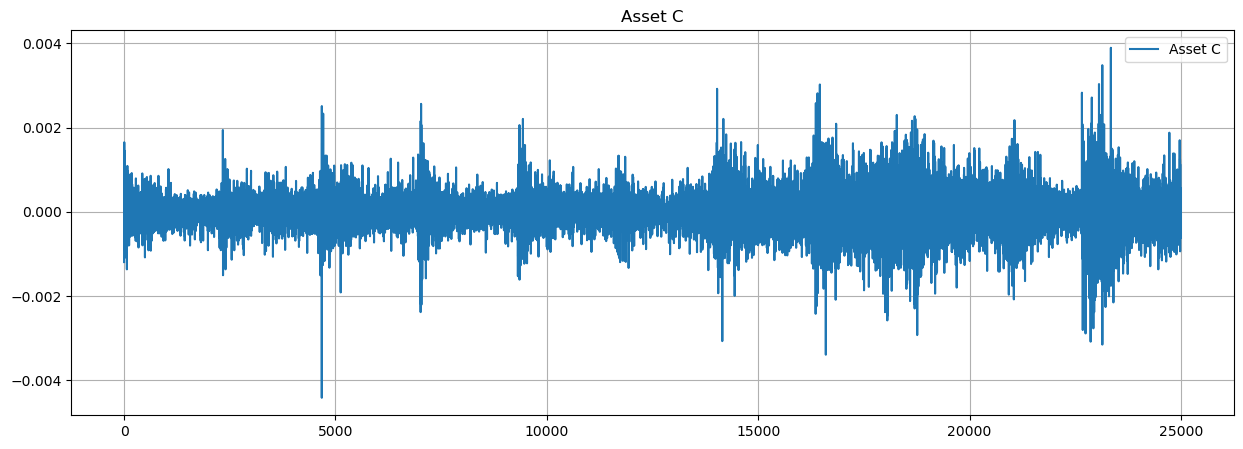

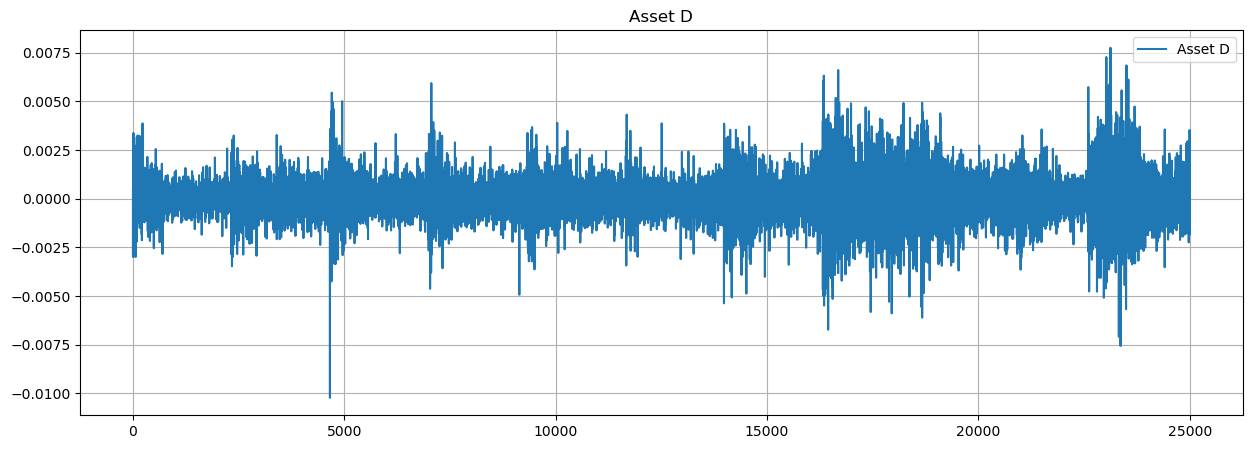

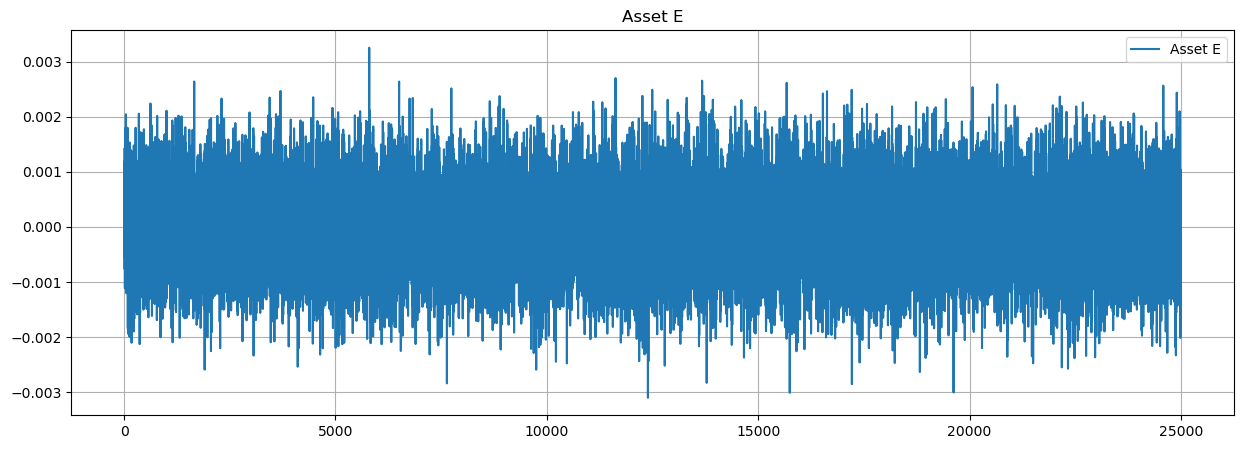

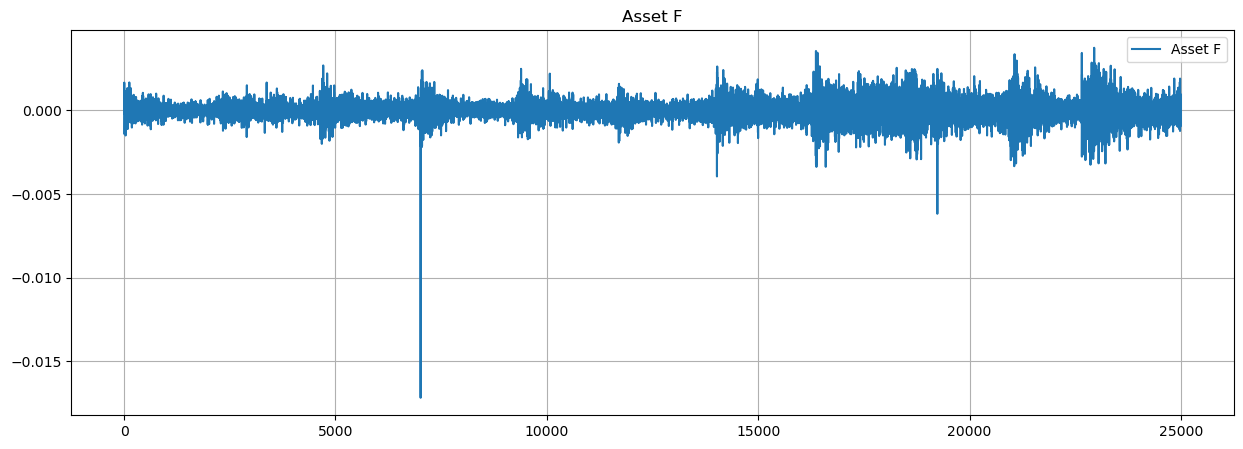

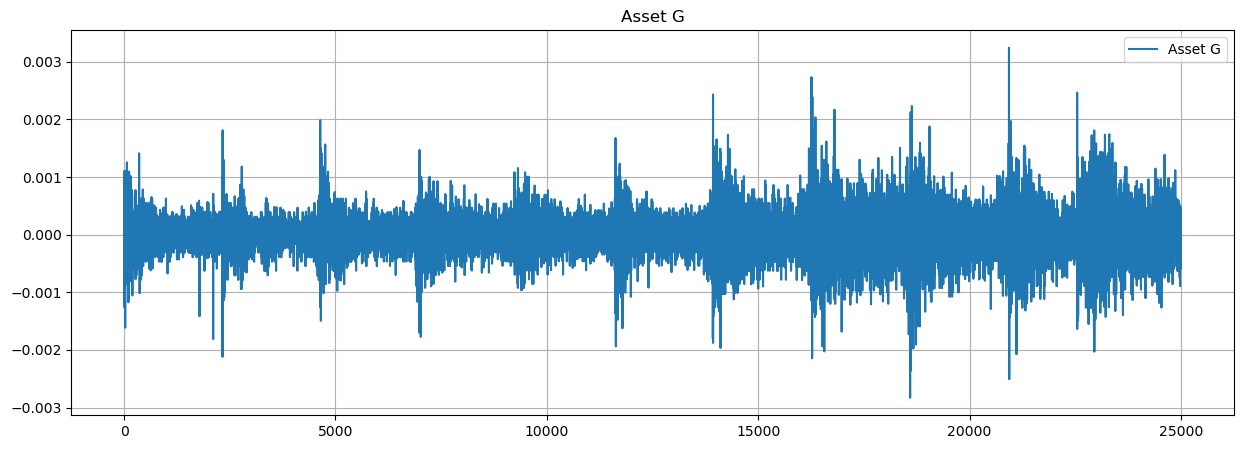

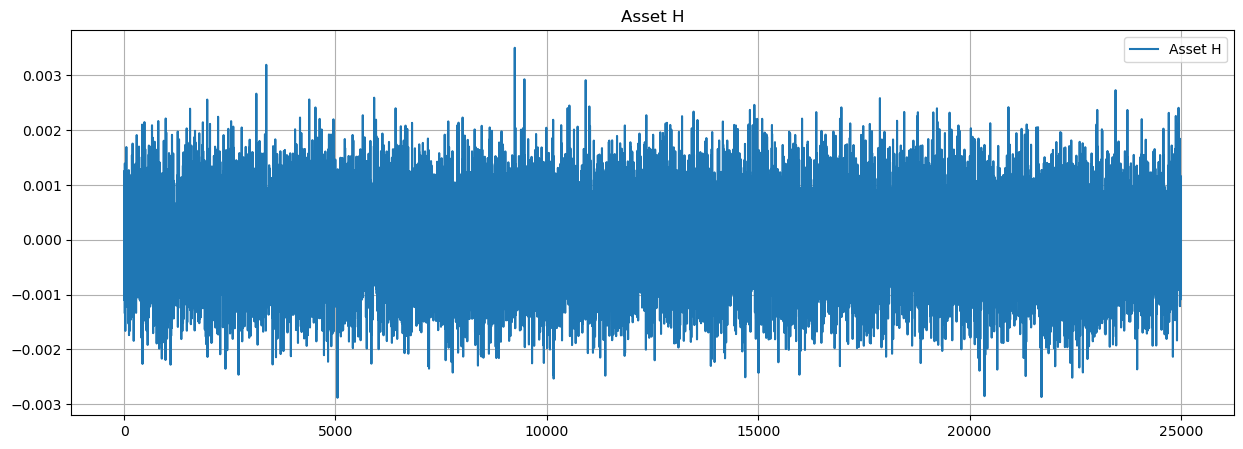

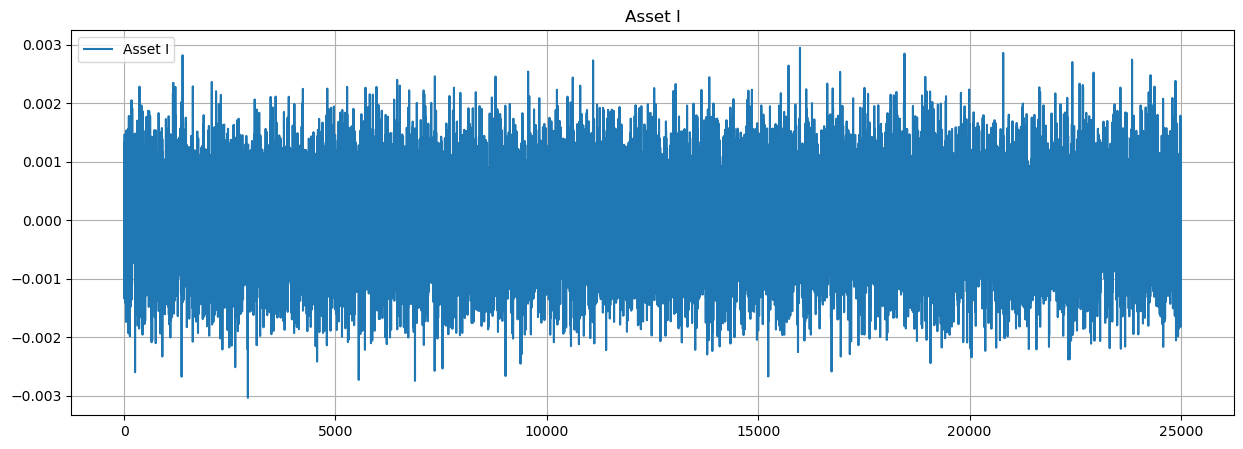

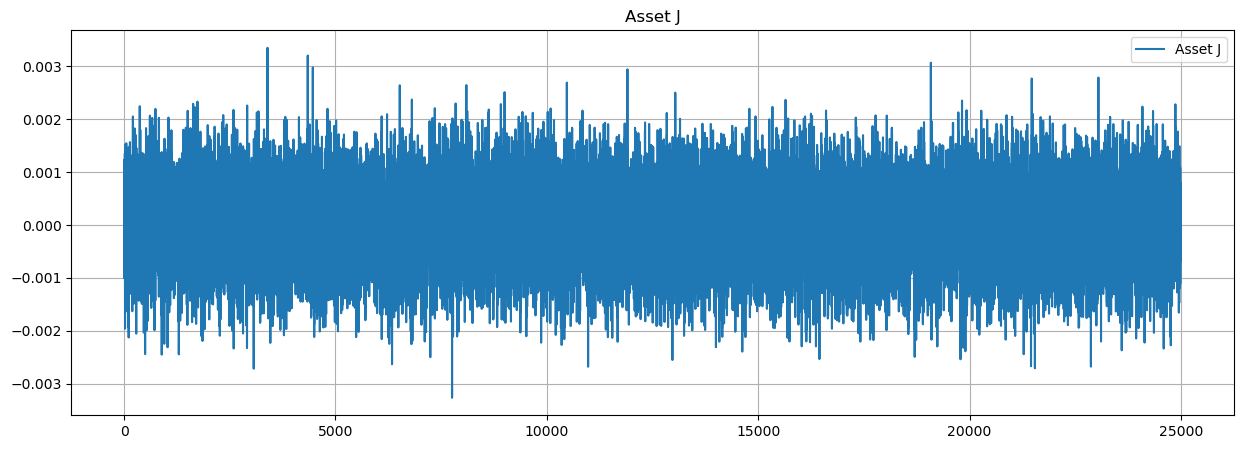

In [31]:
## plot the raw retrun series
for col in tick_df:
    plt.figure(figsize=(15,5))
    tick_df[col].plot()
    plt.title(col)
    plt.grid()
    plt.legend()

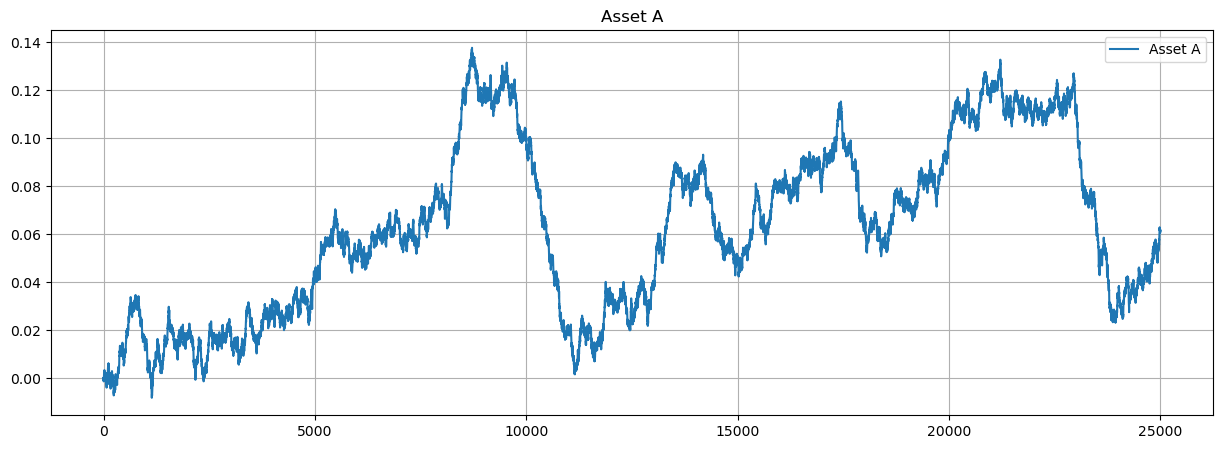

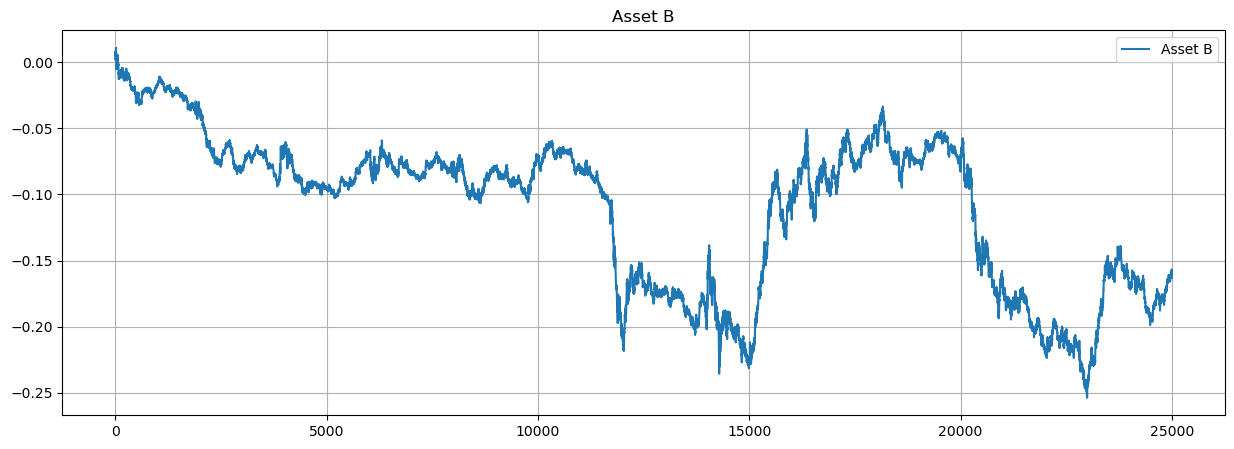

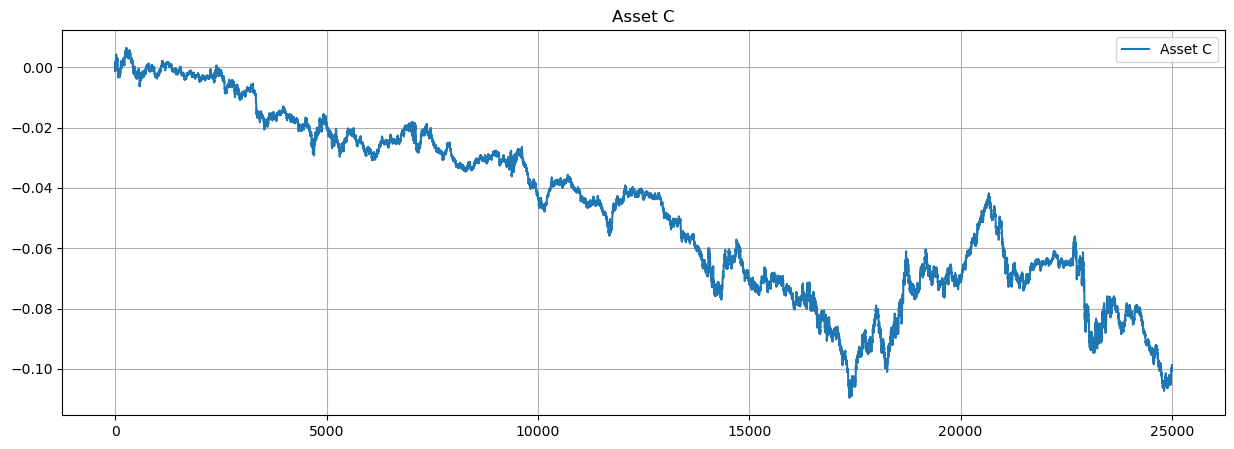

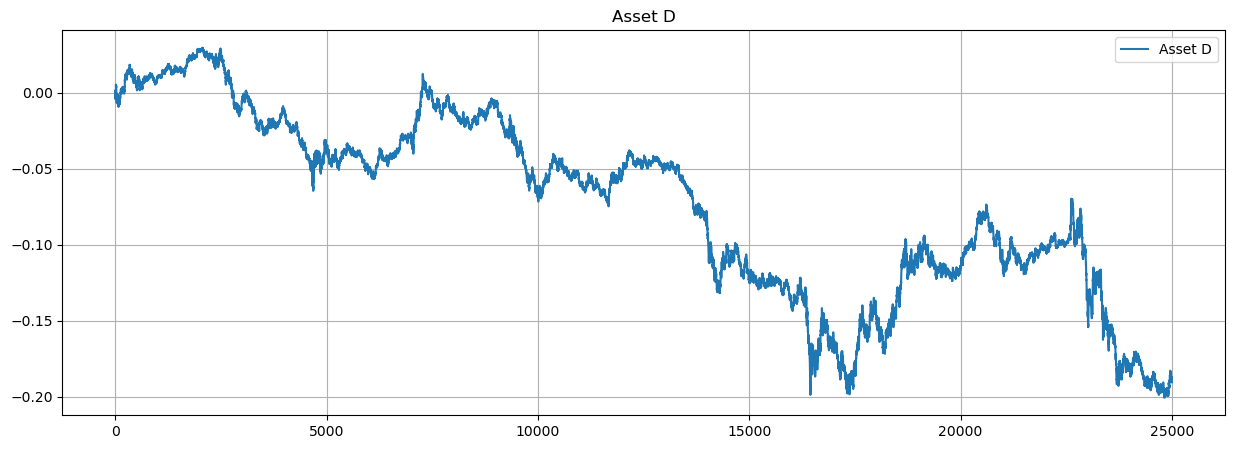

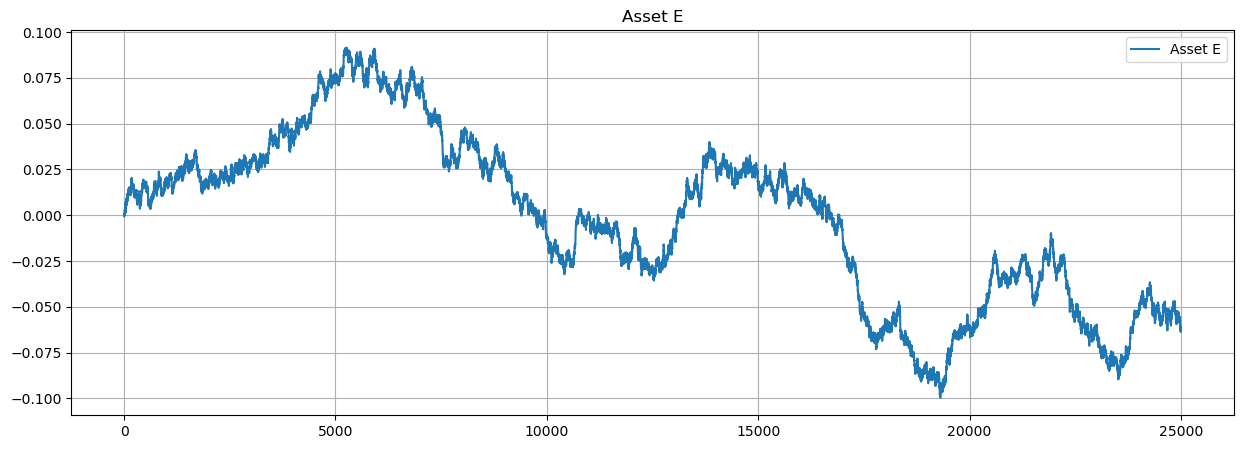

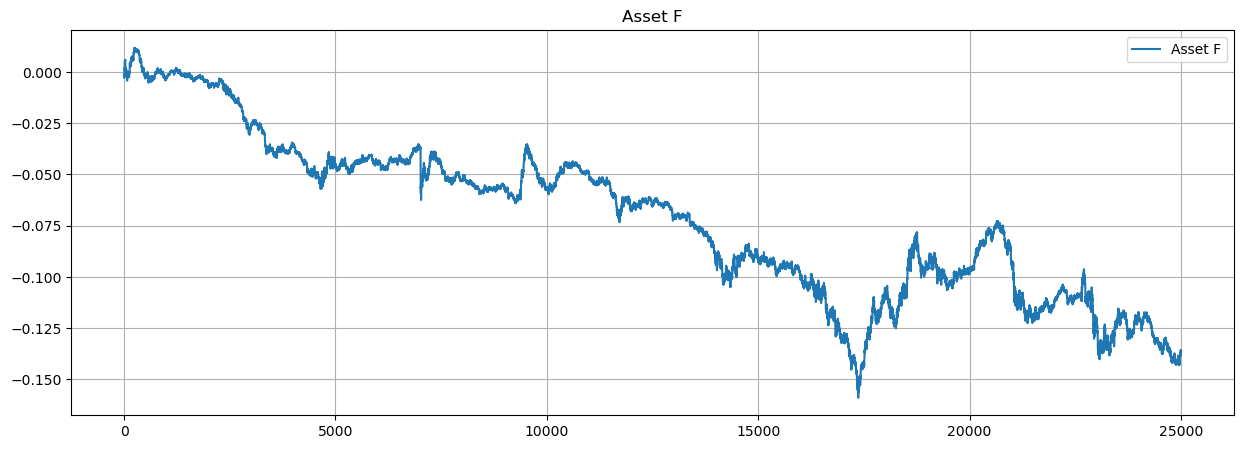

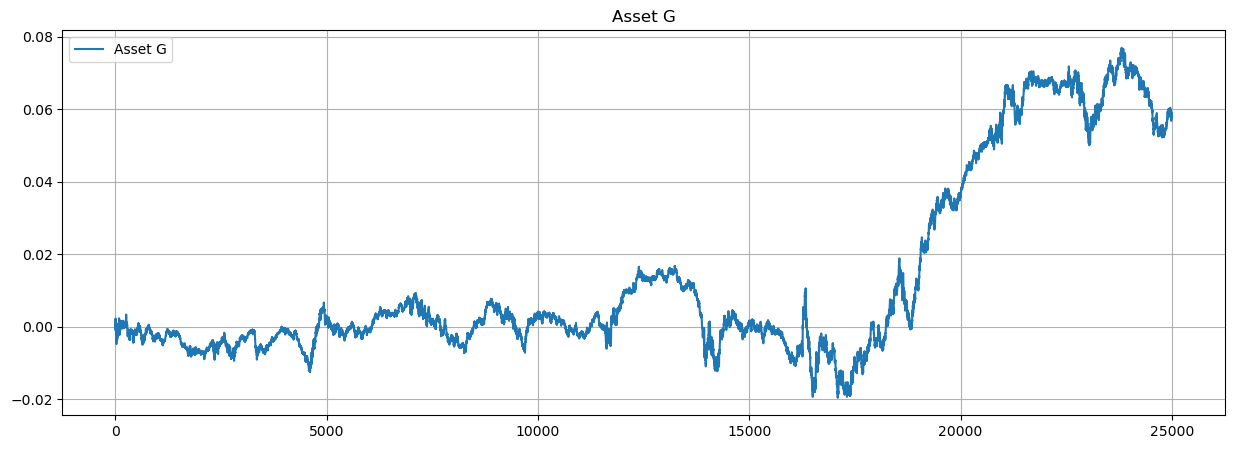

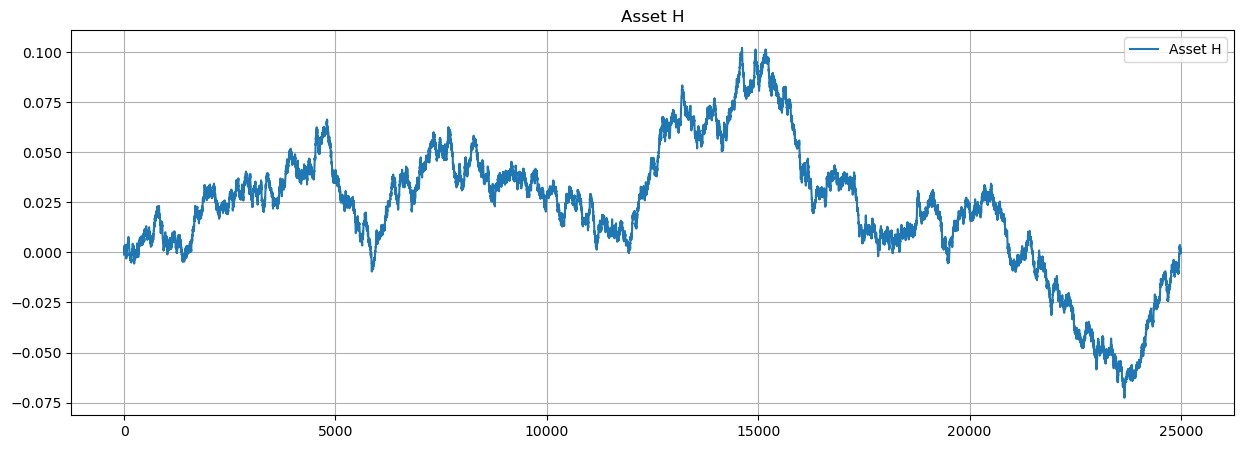

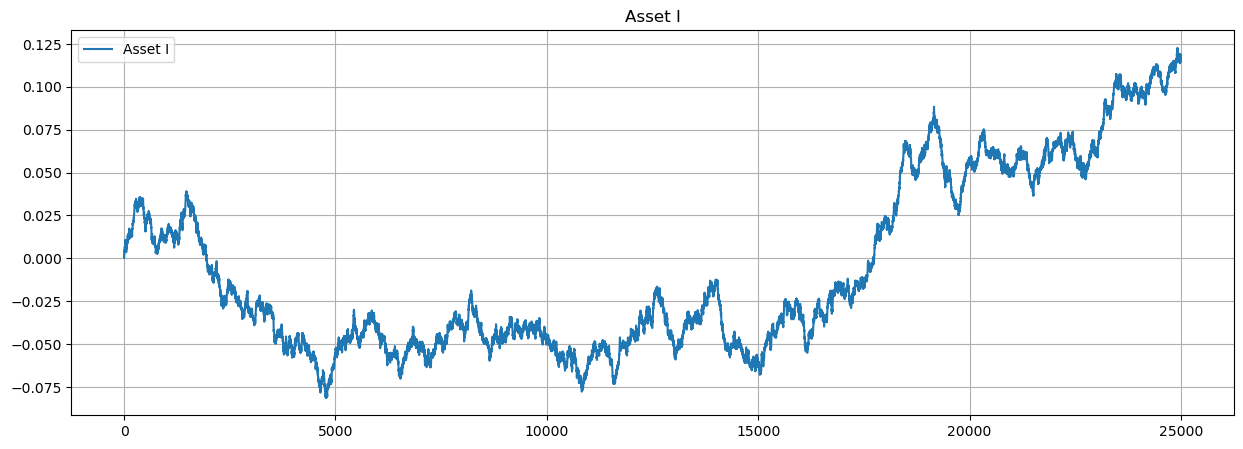

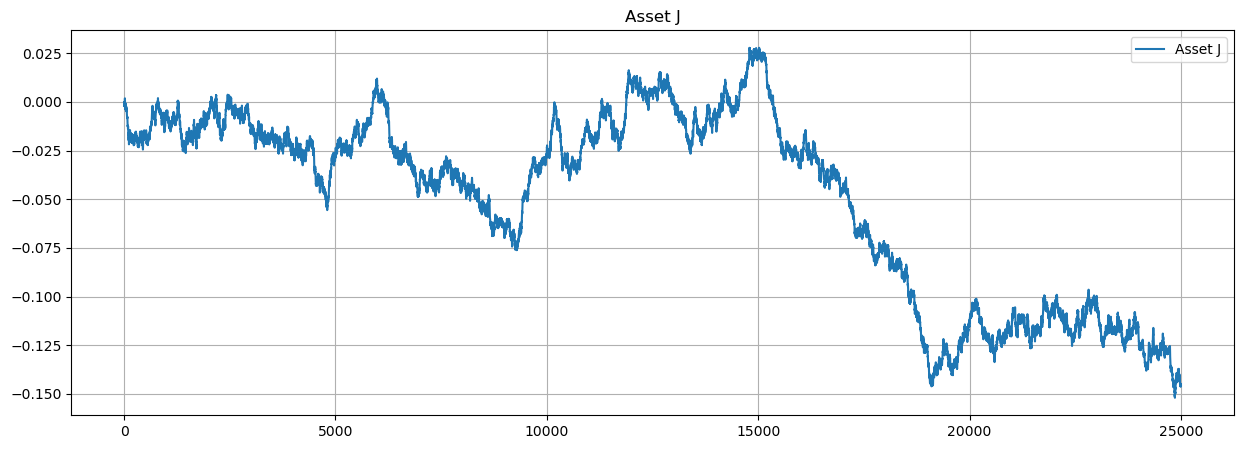

In [32]:
## plot the payoff history 
for col in tick_df:
    plt.figure(figsize=(15,5))
    tick_df[col].cumsum().plot()
    plt.title(col)
    plt.grid()
    plt.legend()

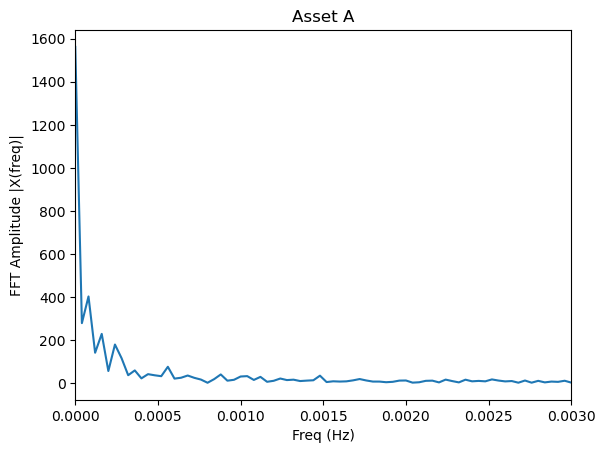

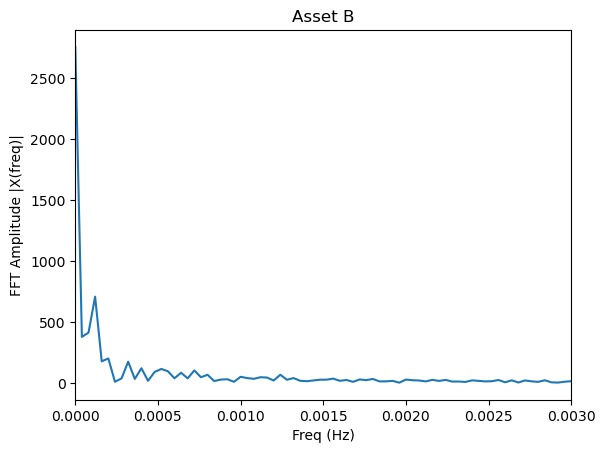

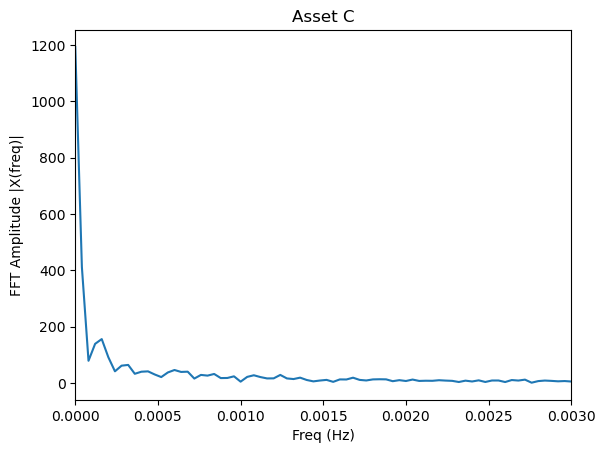

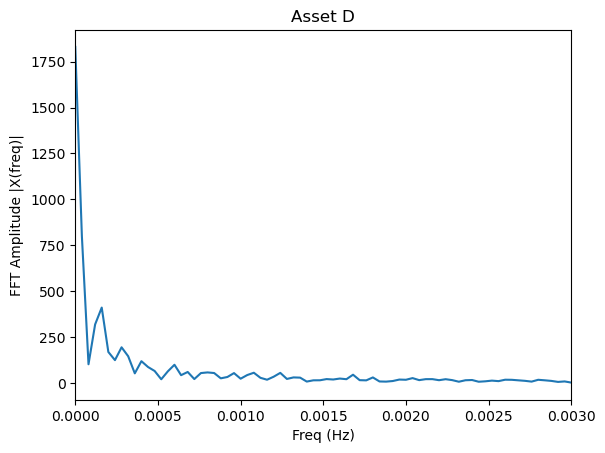

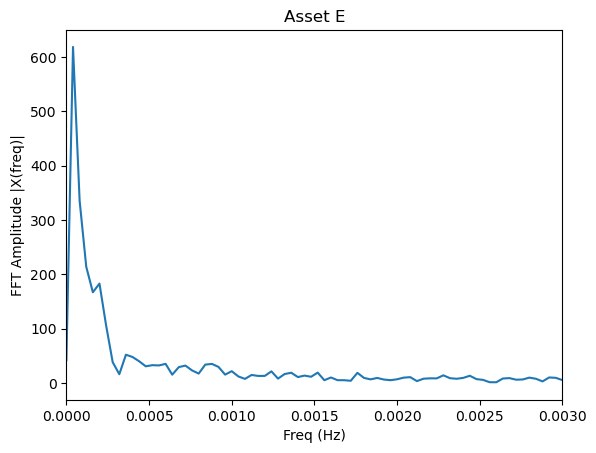

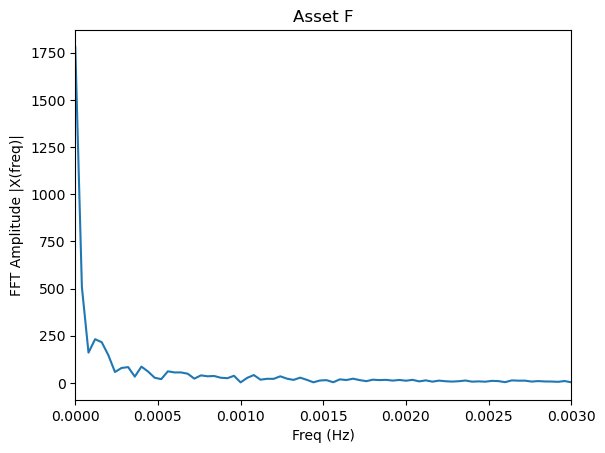

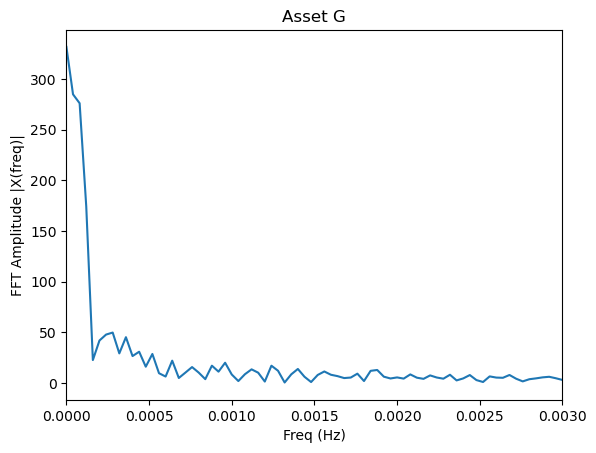

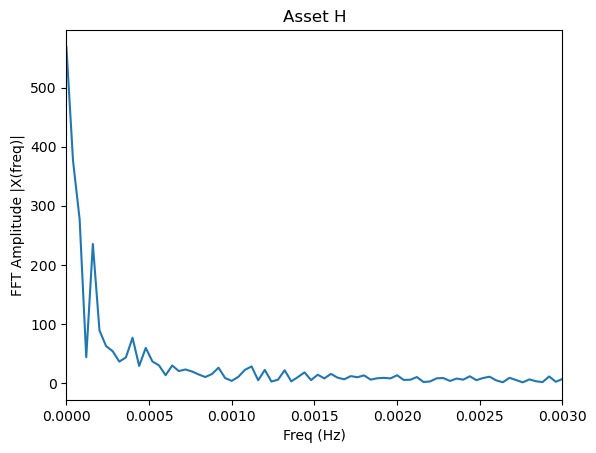

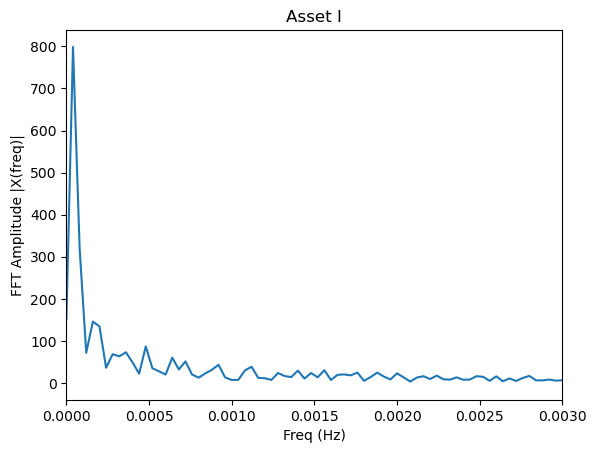

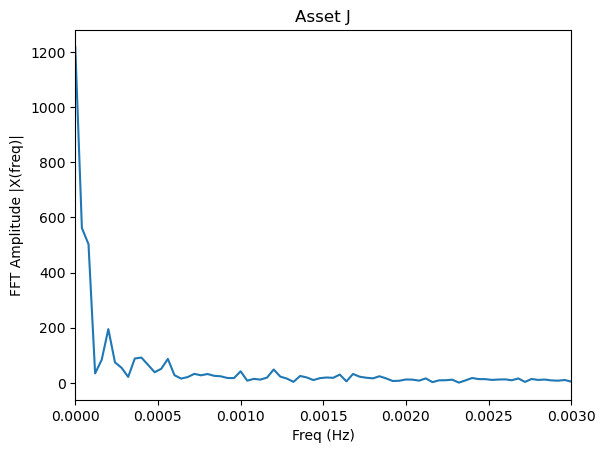

In [33]:
## Fourier Transform on the payoff history
from scipy.fft import fft, fftfreq

for asset in tick_df:
    y = tick_df[asset].cumsum()
    sampling_rate = 1
    ft_y = fft(y.values)
    N = len(y)
    n = np.arange(N)
    T = N/sampling_rate
    freq = n/T

    plt.plot(freq, np.abs(ft_y))
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim([0, 0.003])
    plt.title(asset)
    plt.show();

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


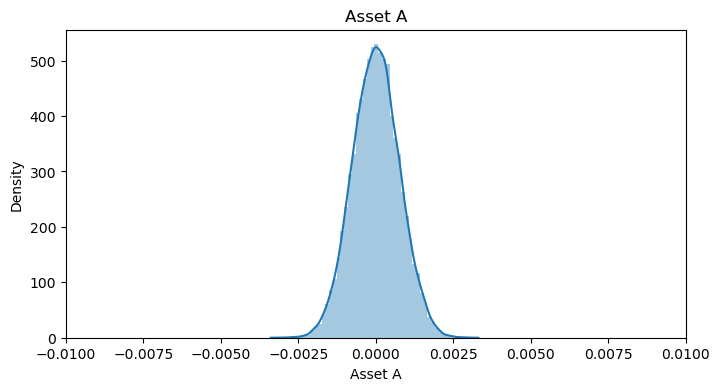

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


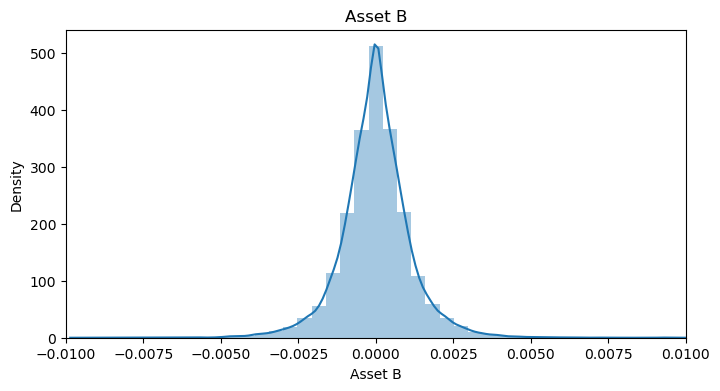

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


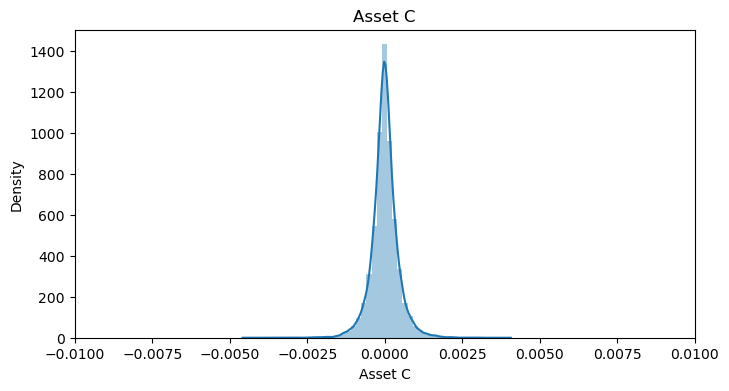

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


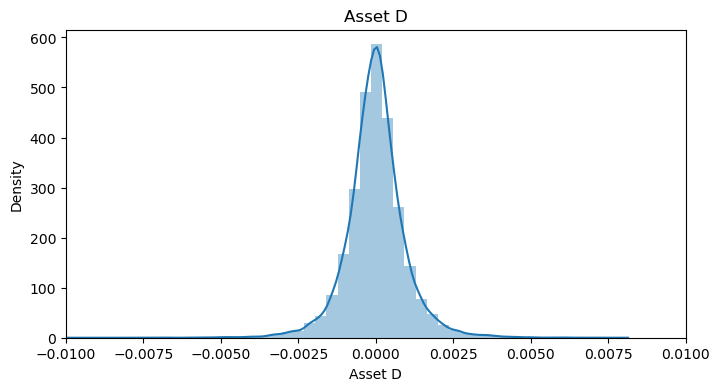

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


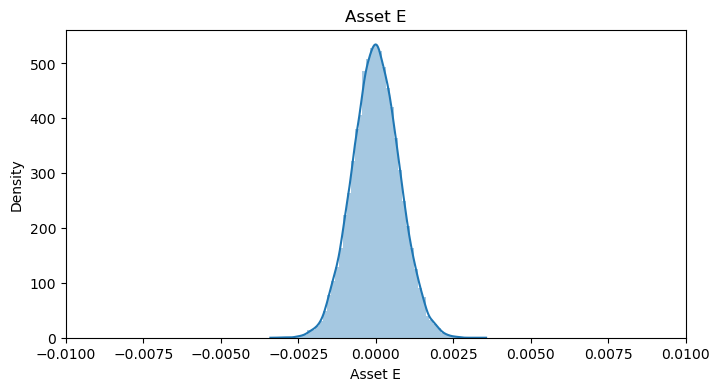

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


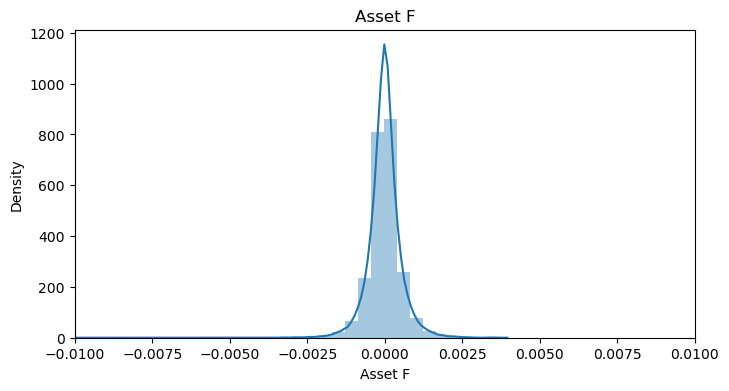

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


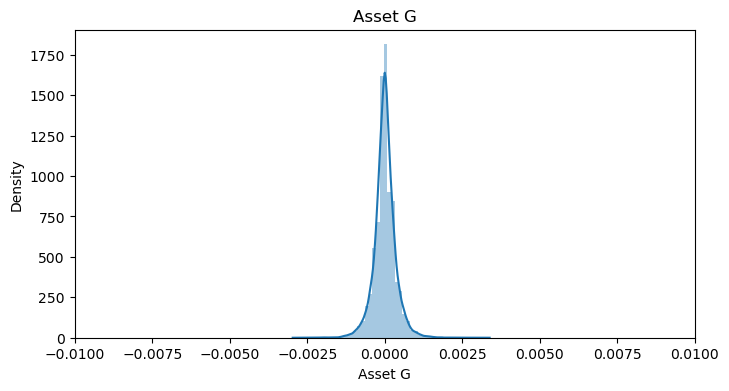

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


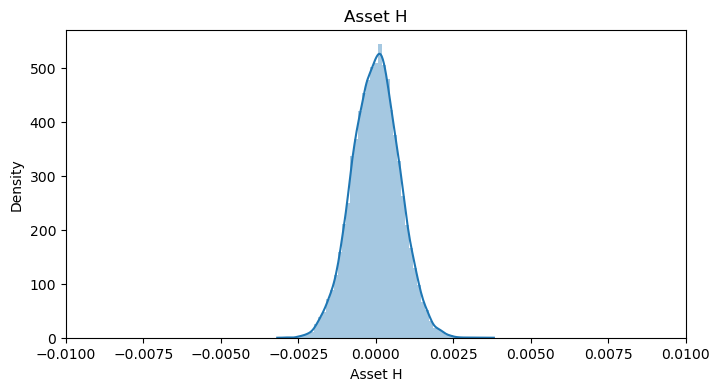

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


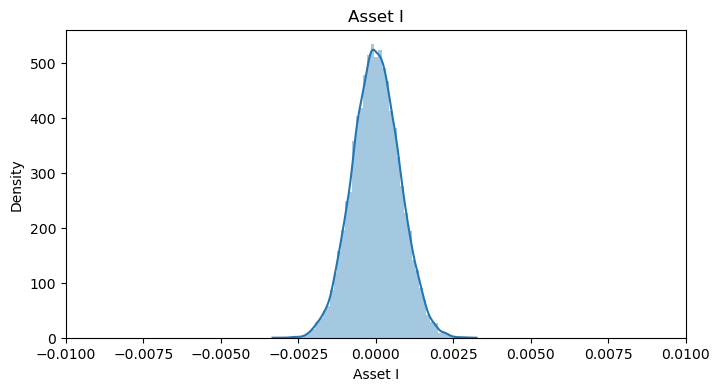

C:\Users\Hoo King Lau\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


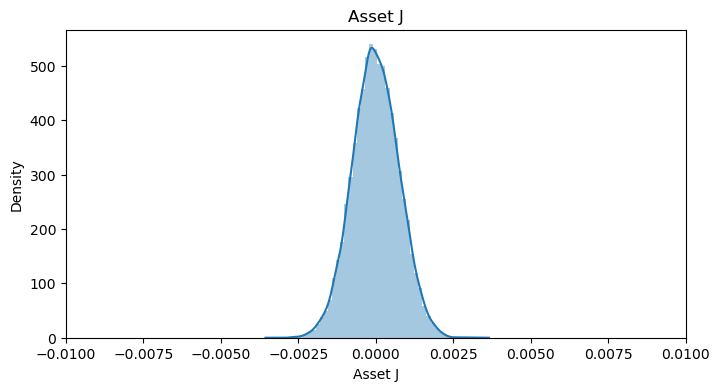

In [34]:
## Visualise the distribution of each return
for col in tick_df:
    plt.figure(figsize=(8,4))
    sns.distplot(tick_df[col])
    plt.xlim([-0.01, 0.01])
    plt.title(col)
    plt.show();

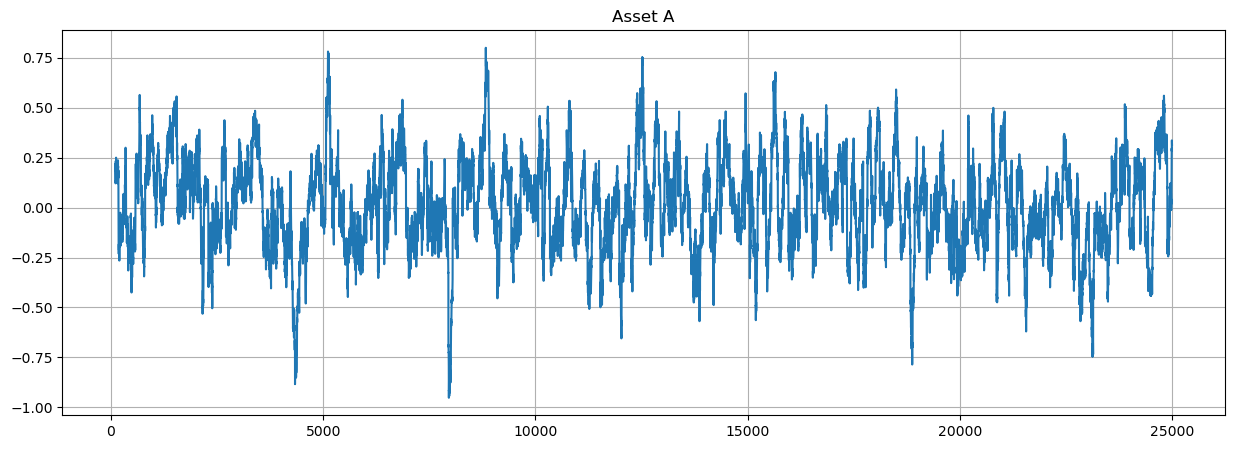

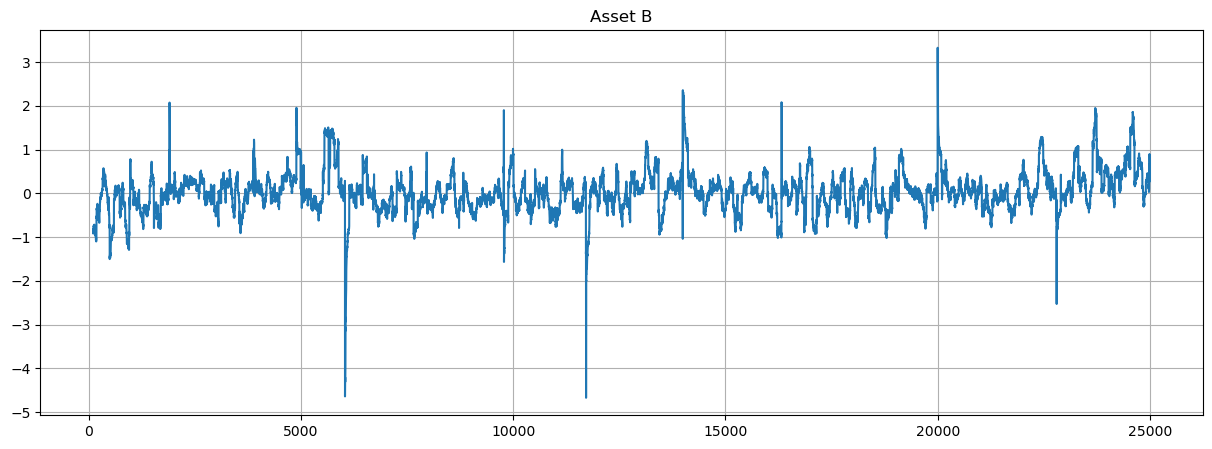

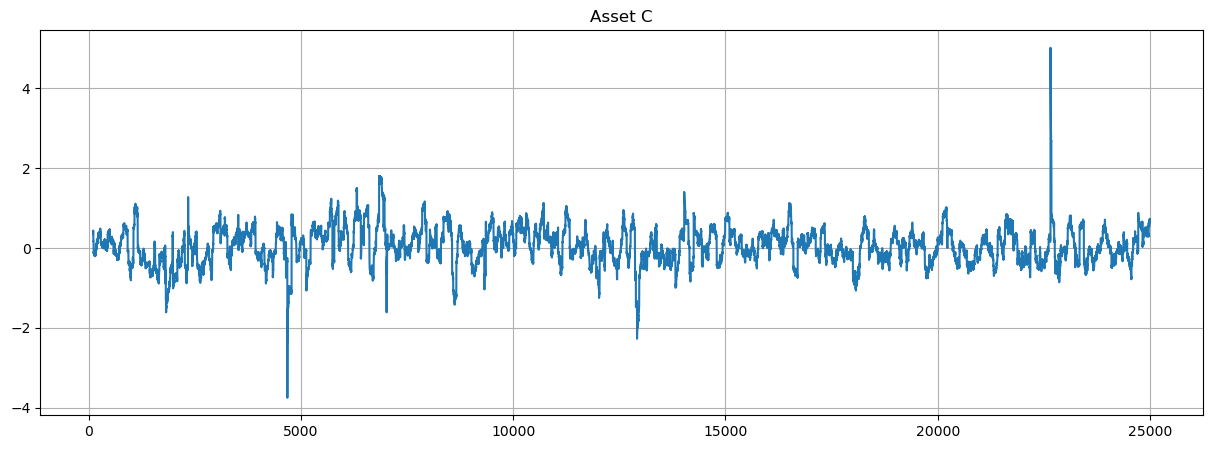

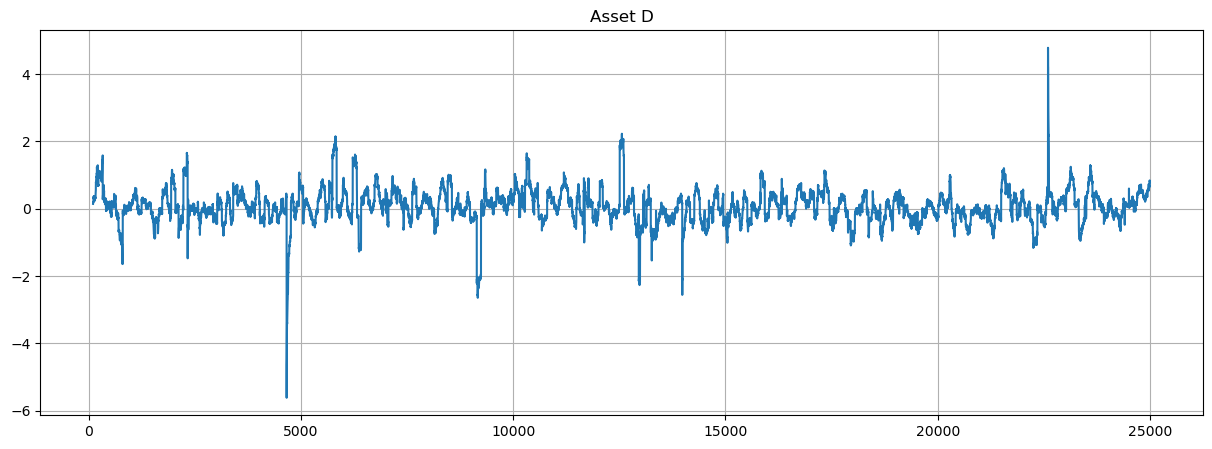

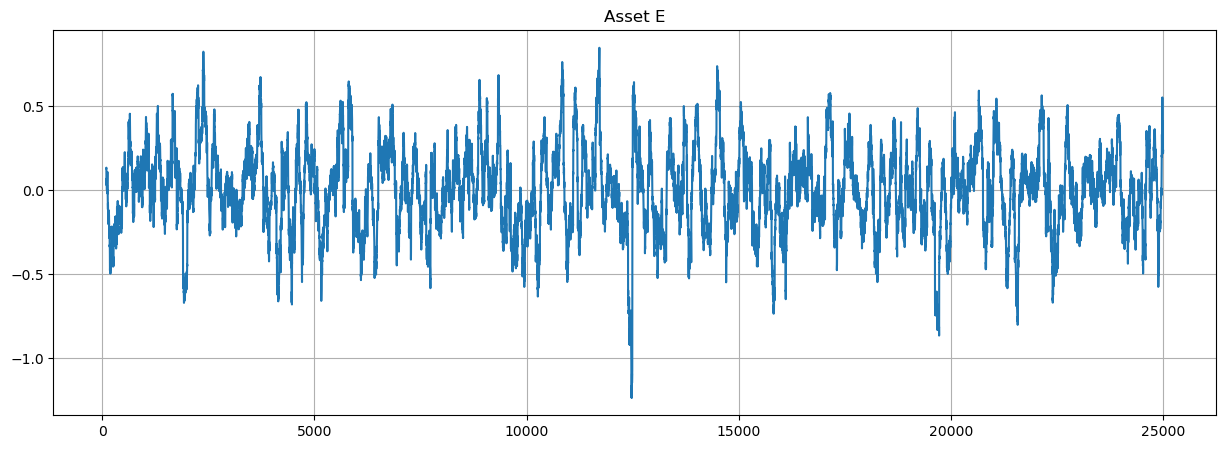

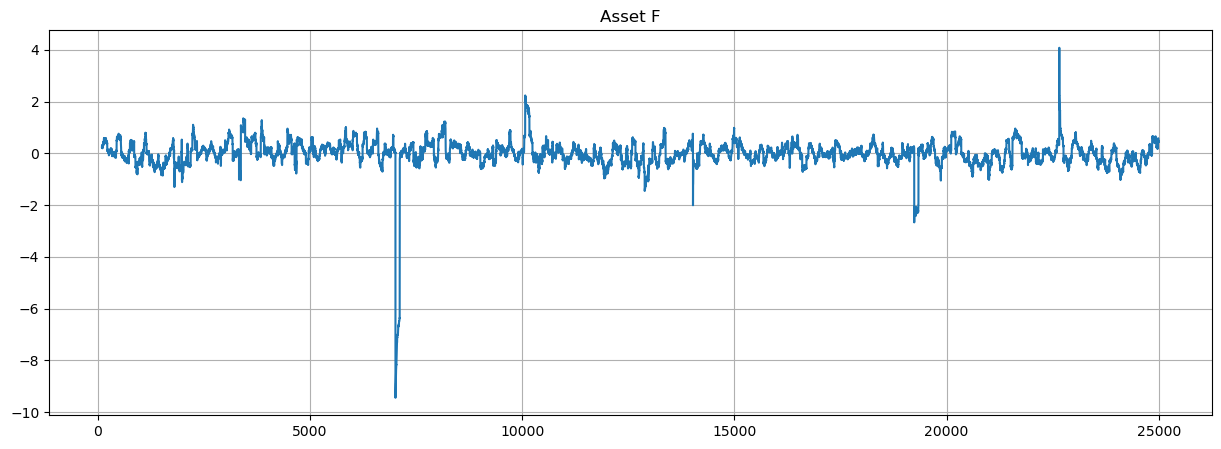

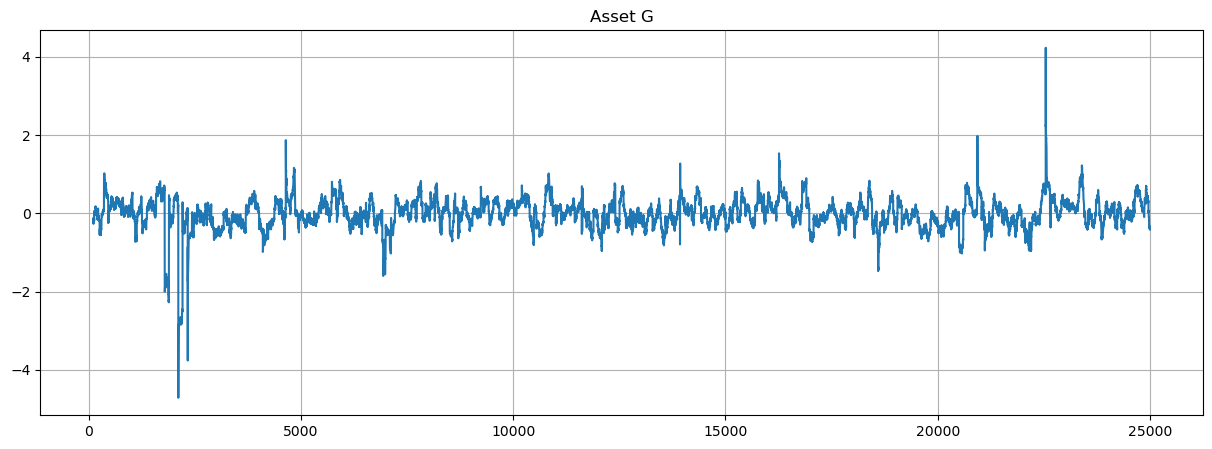

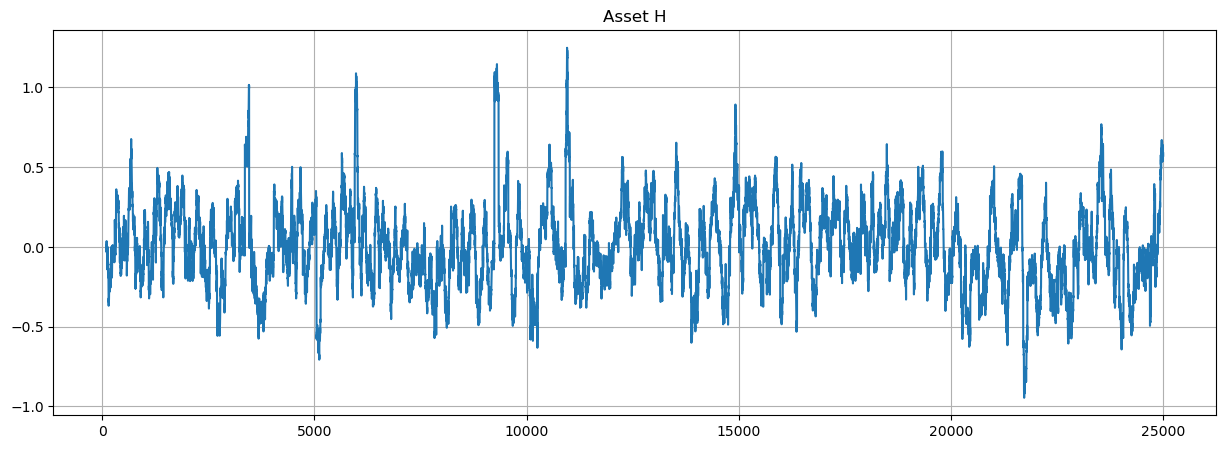

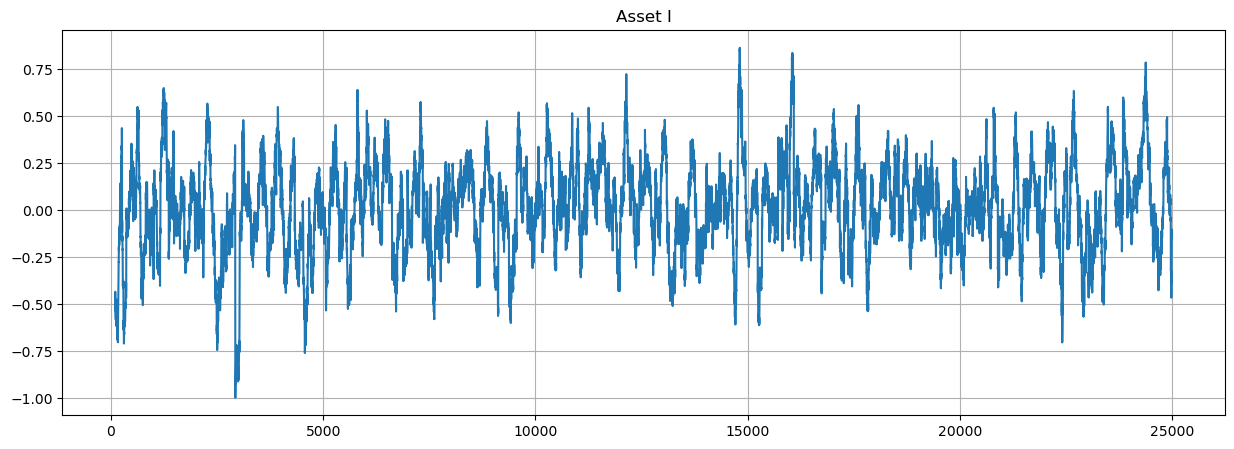

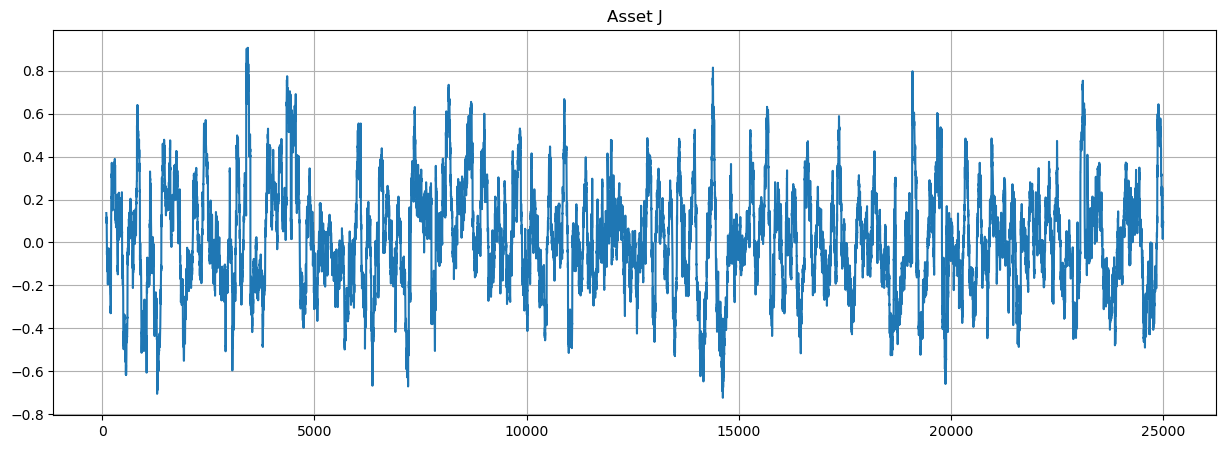

In [35]:
rolling_skew_df = tick_df.rolling(window=100).skew().dropna()
for col in rolling_skew_df:
    plt.figure(figsize=(15,5))
    rolling_skew_df[col].plot()
    plt.title(col)
    plt.grid()

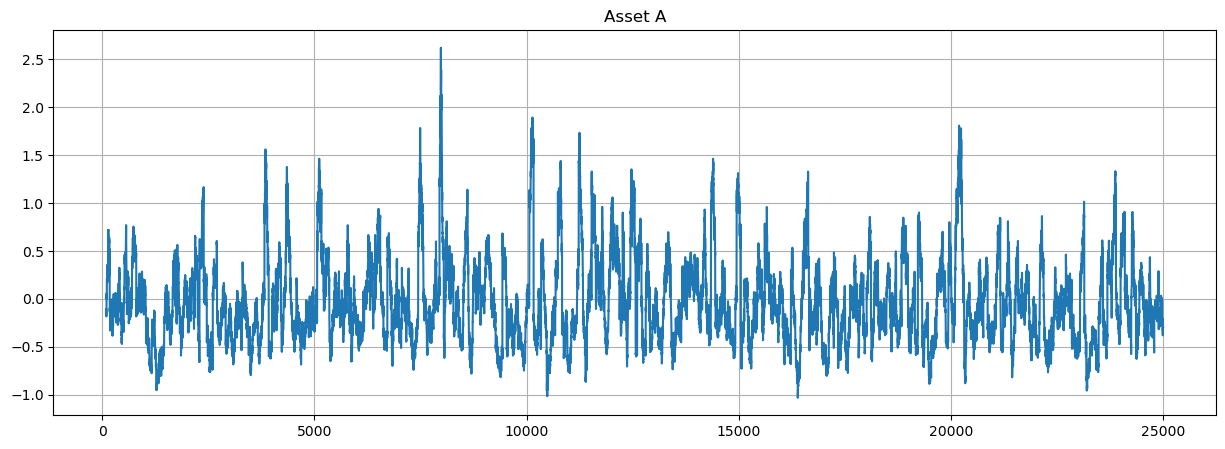

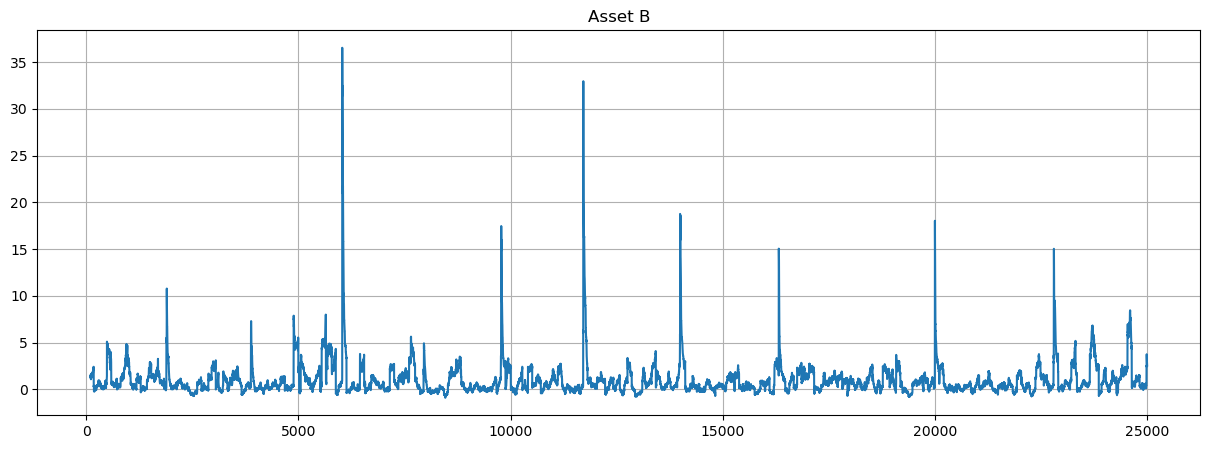

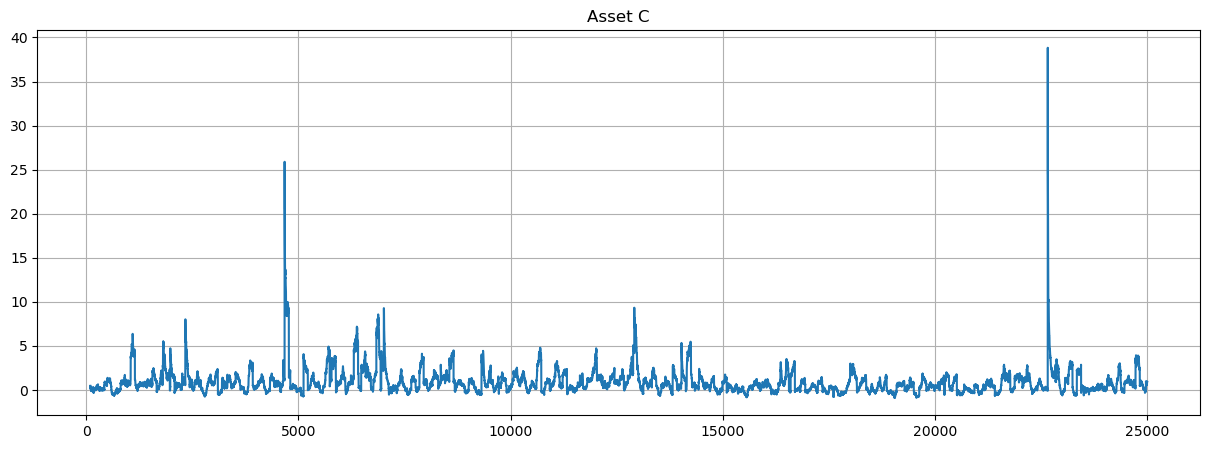

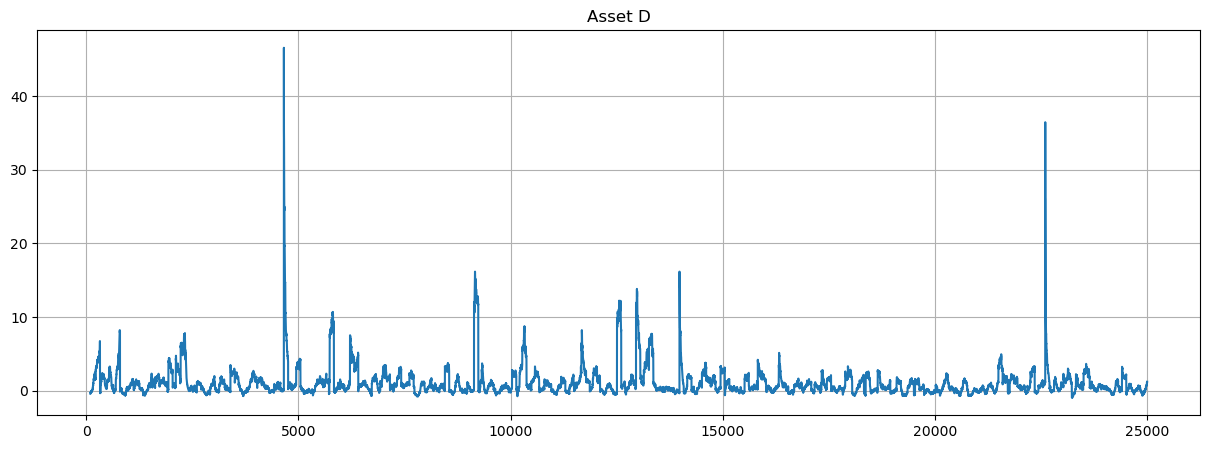

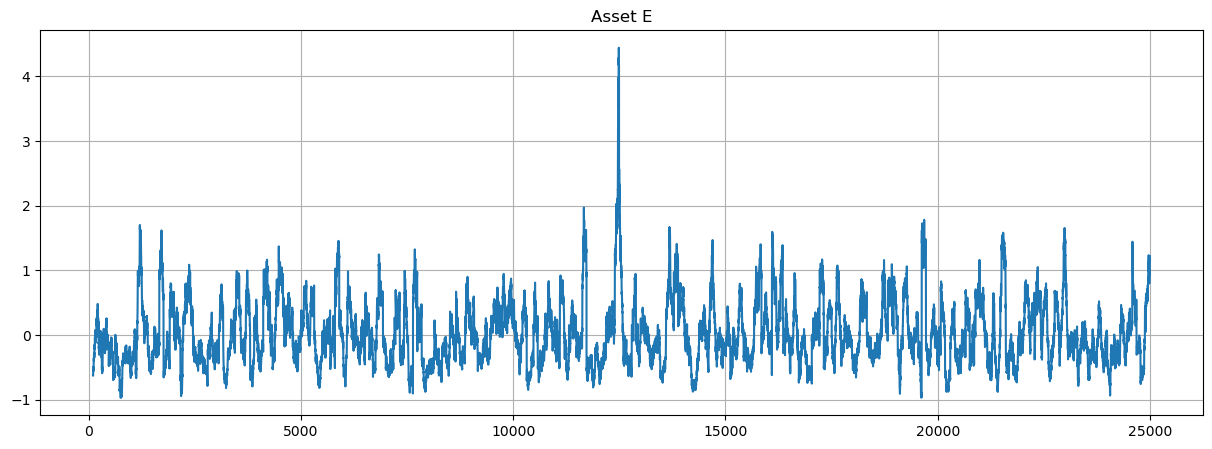

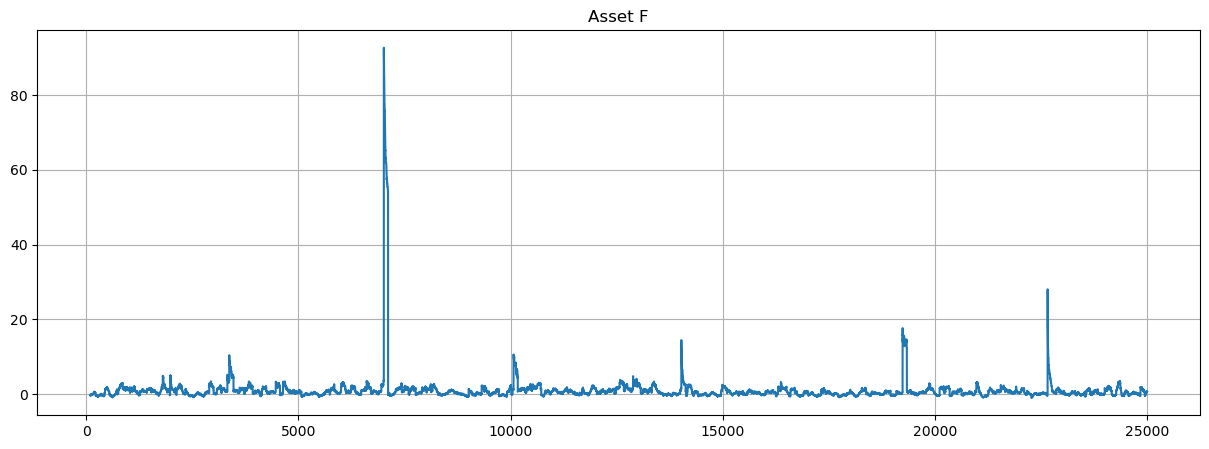

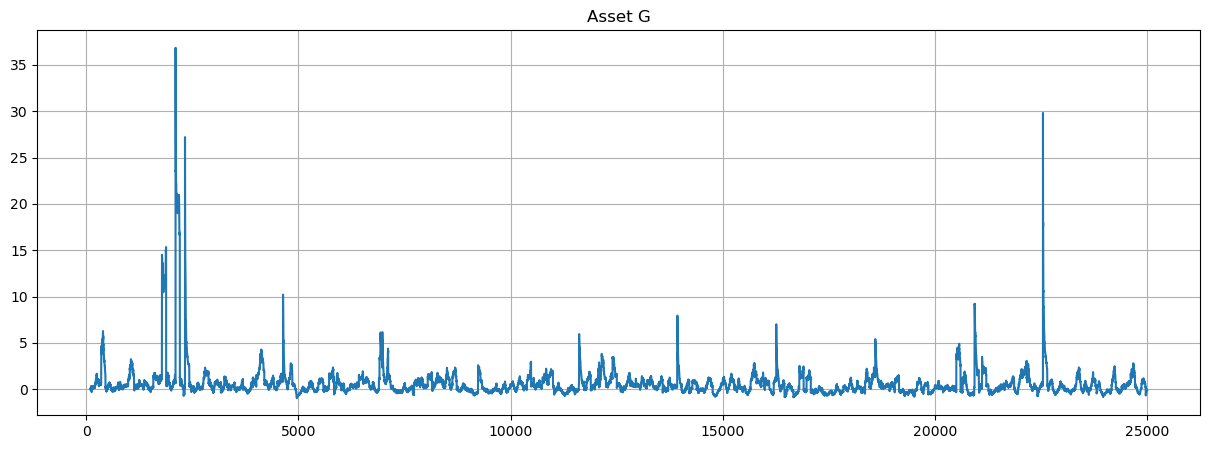

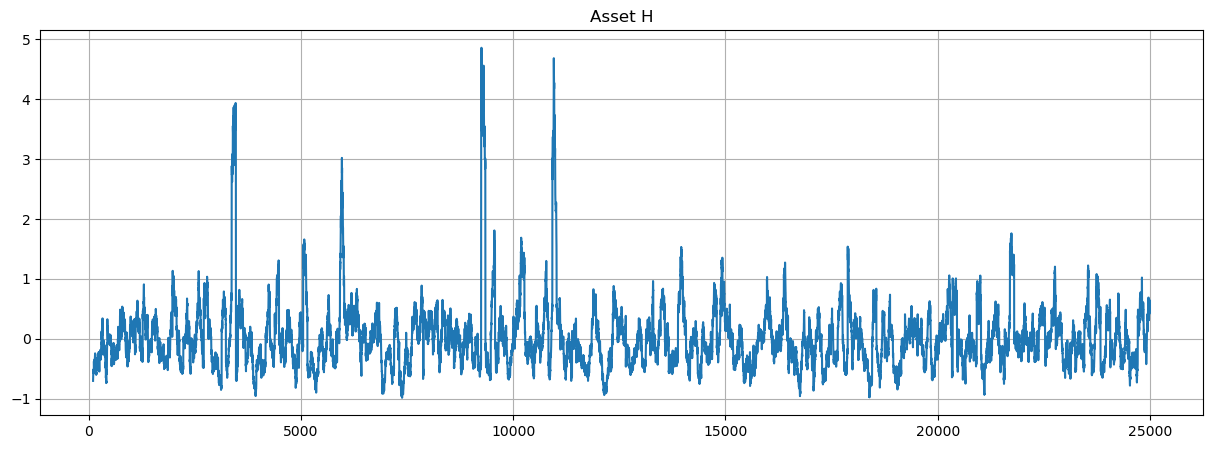

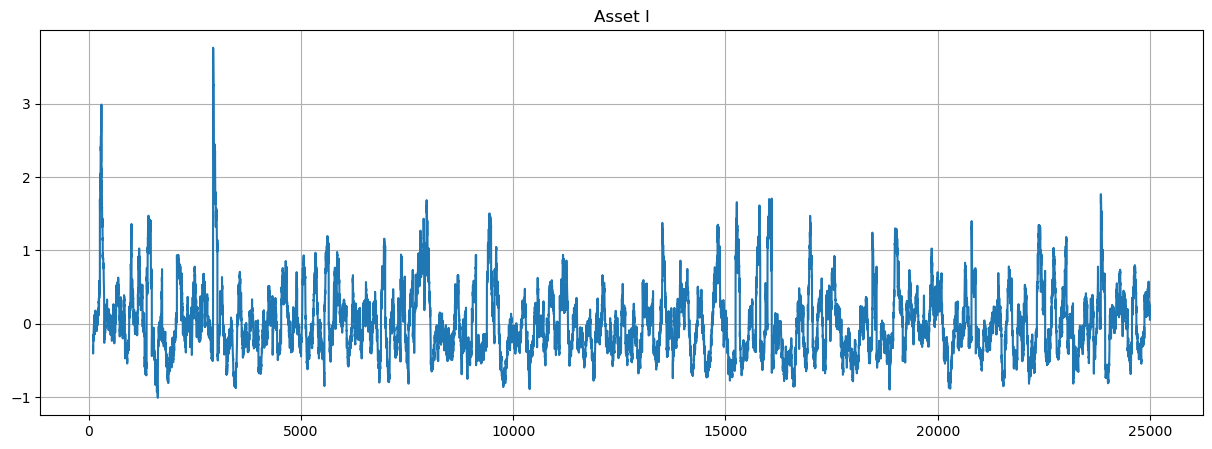

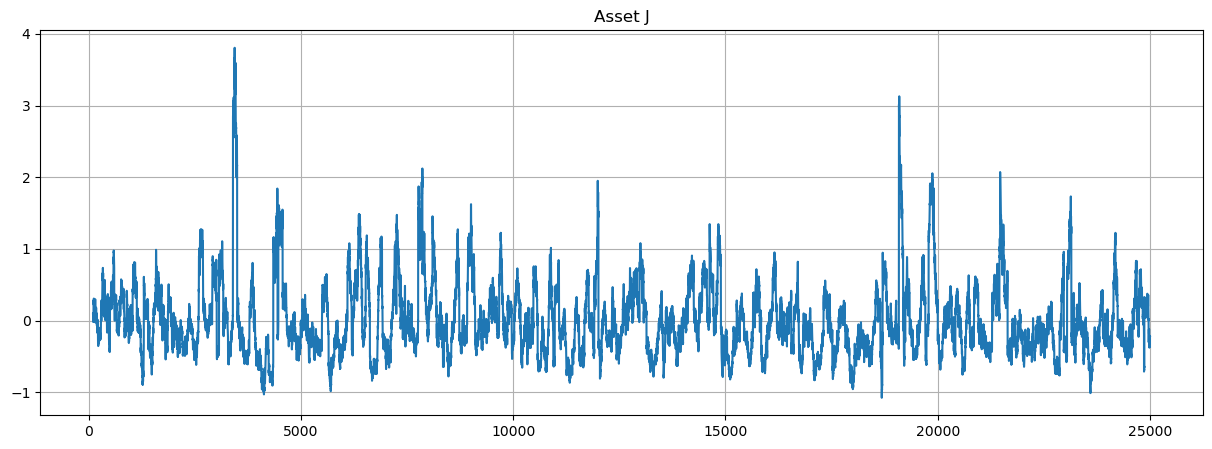

In [36]:
rolling_kurt_df = tick_df.rolling(window=100).kurt().dropna()
for col in rolling_kurt_df:
    plt.figure(figsize=(15,5))
    rolling_kurt_df[col].plot()
    plt.title(col)
    plt.grid()

In [37]:
stats_df = pd.concat(
    [
        tick_df.skew().rename('skew'), 
        tick_df.kurtosis().rename('kurtosis')
    ],
    axis=1,
    
)
stats_df

skew   kurtosis
Asset A  0.018388  -0.031174
Asset B  0.171612   5.852532
Asset C  0.028124   4.910682
Asset D  0.030097   4.936043
Asset E  0.004274   0.036528
Asset F -1.398887  48.225848
Asset G  0.083216   3.997894
Asset H  0.002284  -0.001301
Asset I  0.017199  -0.016427
Asset J  0.008868   0.003103

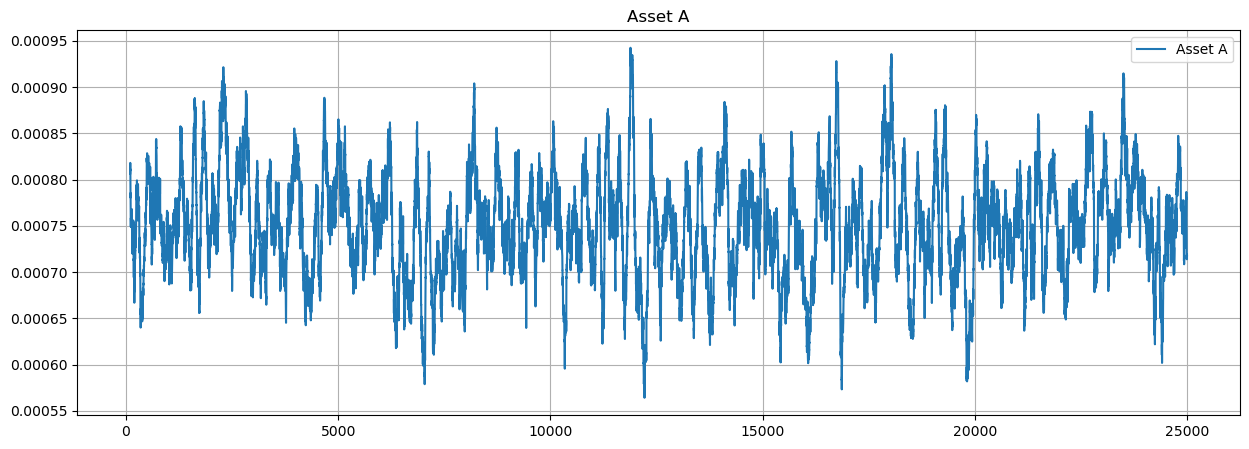

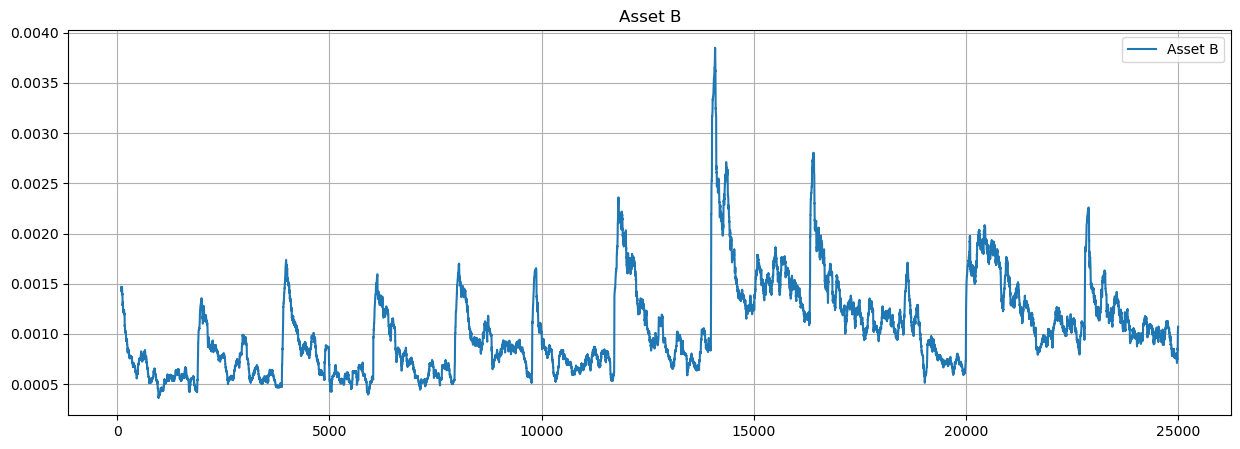

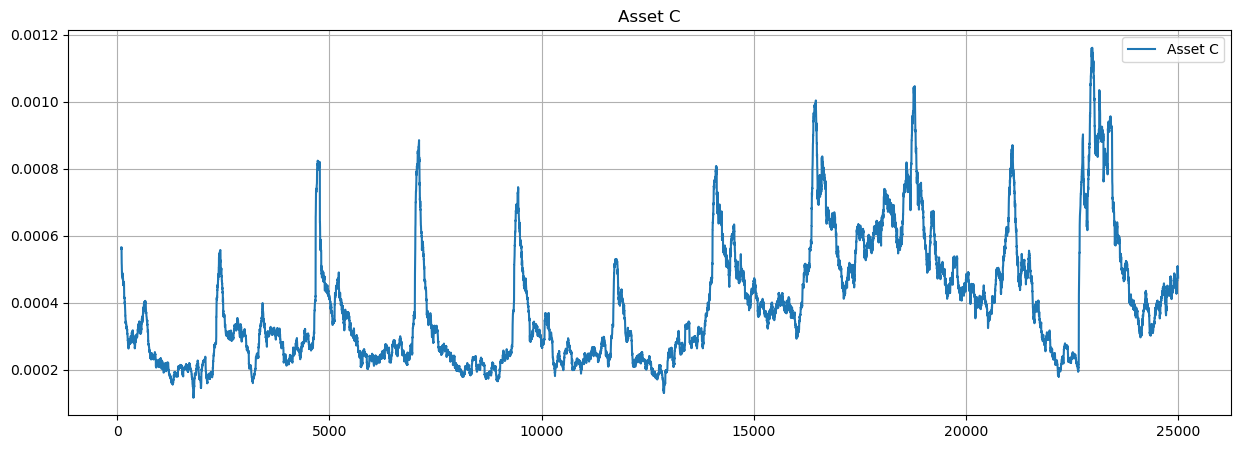

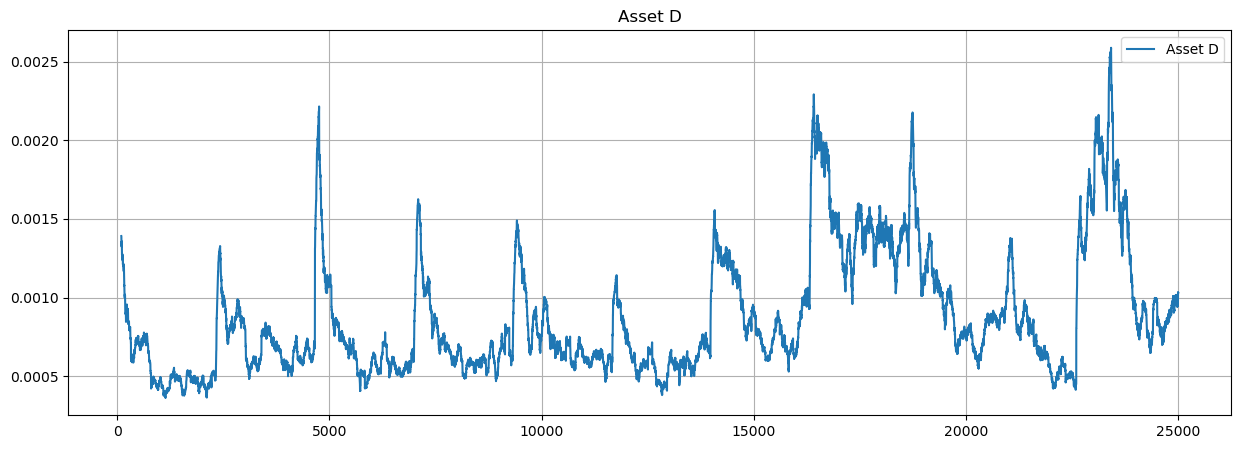

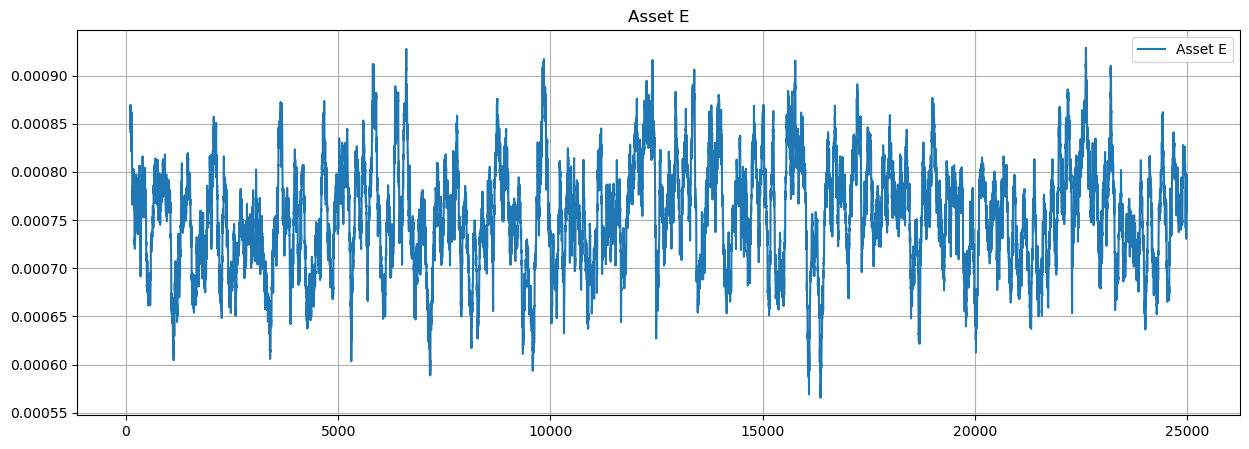

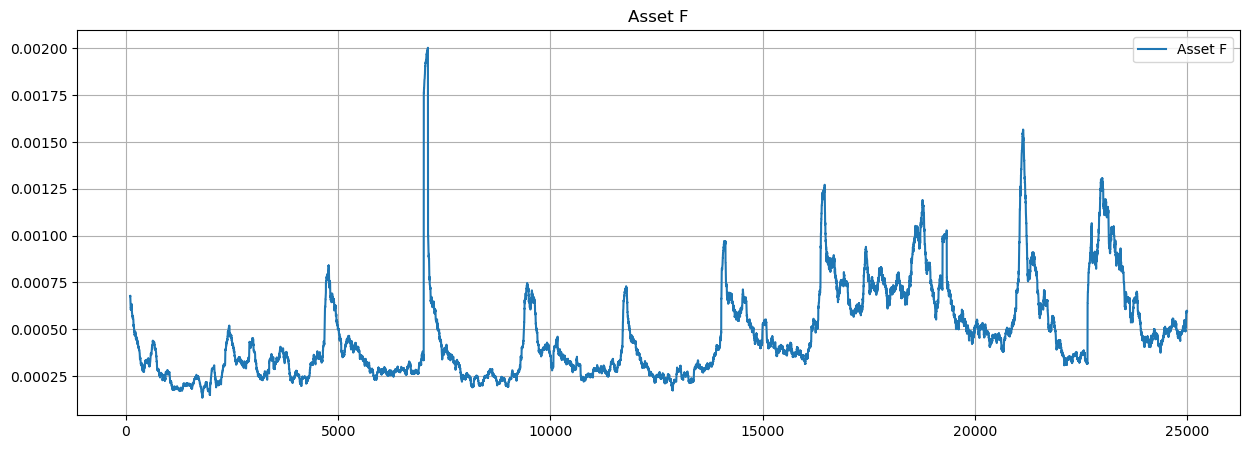

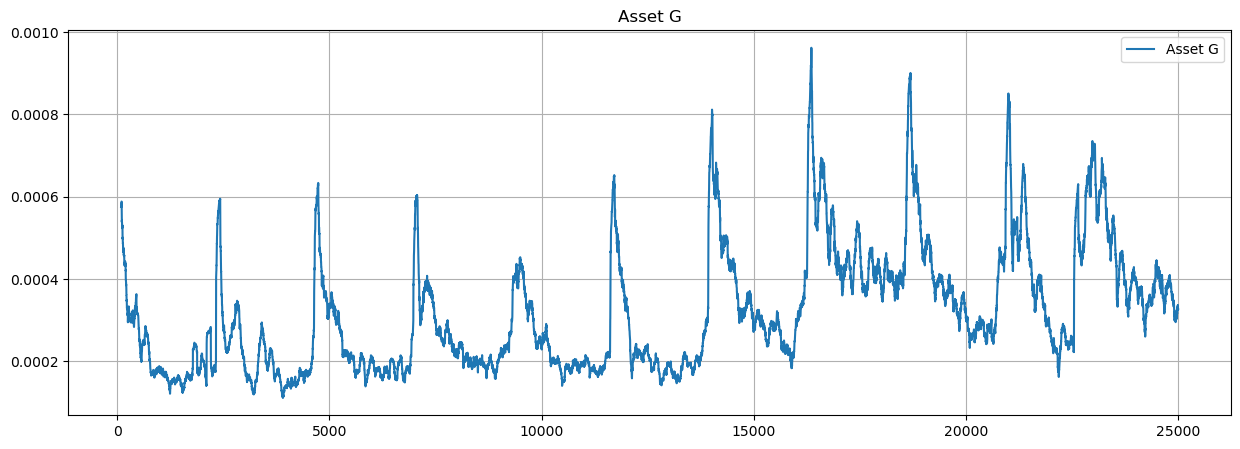

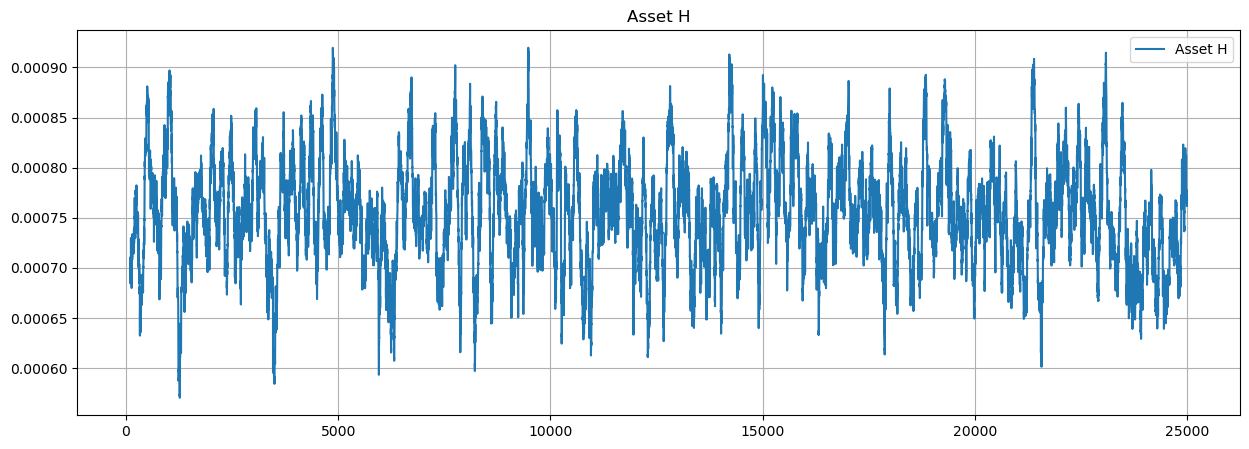

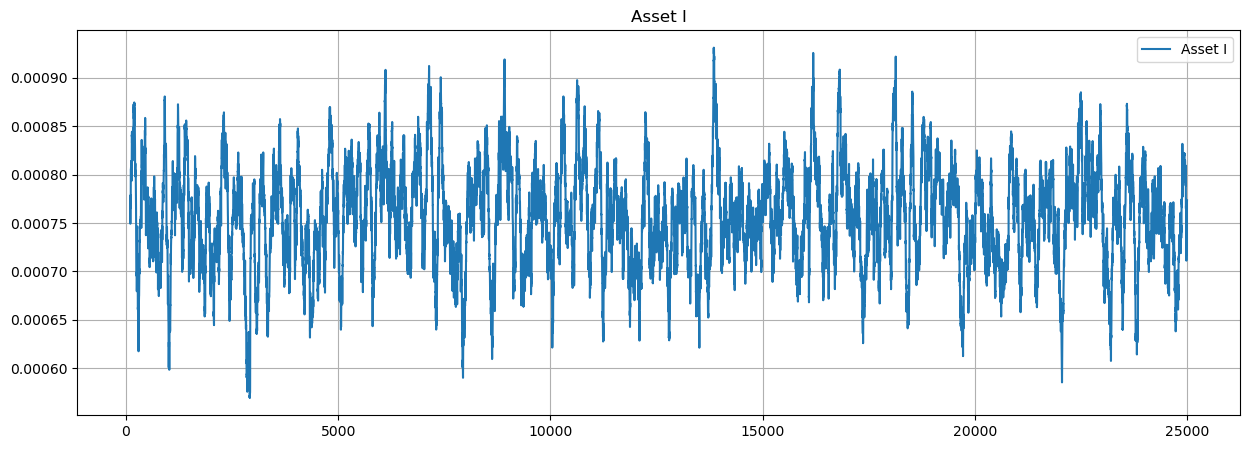

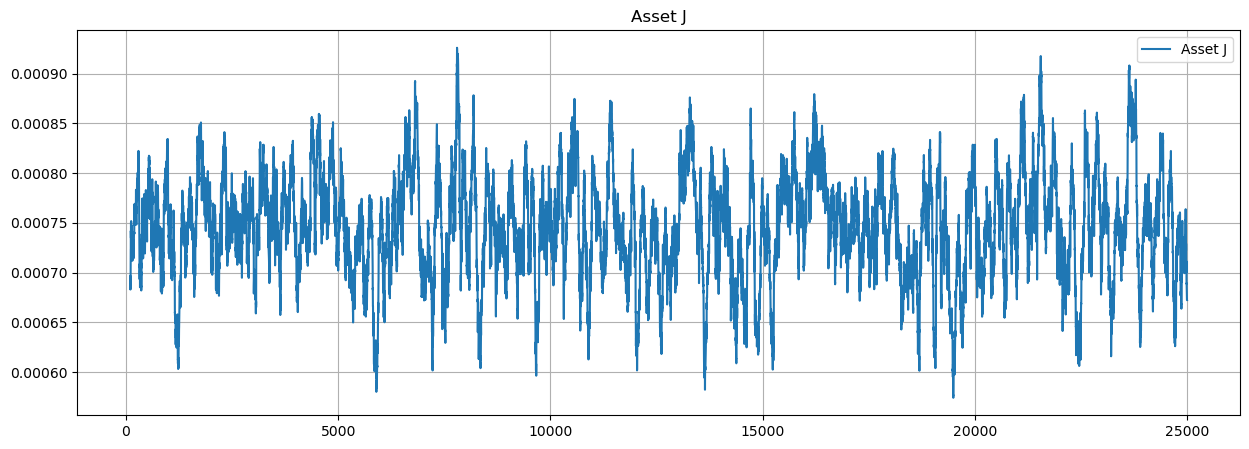

In [38]:
## Rolling standard deviation of the returns - historical realsied vols
rolling_std_df = tick_df.rolling(window=100).std().dropna()
for col in rolling_std_df:
    plt.figure(figsize=(15,5))
    rolling_std_df[col].plot()
    plt.title(col)
    plt.grid()
    plt.legend()

- By inspection, the 10 assets can be divided into two groups:
 - Group1: Asset A, E, H, I, J, where the return time history looks like a white noise signal
 - Group2: Asset B, C, D, F, G, where the return time history looks like a white noise signal whose amplitude has been periodically modulated.
- It is hard to decern which group consists of genuine data and which one synthetic by just inspecting their payoff (accumulative return) history or the Fourier transform of the time history, because there is no feature which differentiates one group from the other.
- The distributions of the returns suggest that Group 1 tend to have a more Gaussian-like distribution, whereas the distributions from Group 2 tend to have a sharper peak as well as heavier tails on either side. The heavier tails are reflected by the much larger kurtosis of those distributions in Group 2.
- The rolling std of the returns of the assets from both groups is a bit more telling. The realised vols of all assets exhibit the mean-reversion. However, the patterns of the realised vols the from Group 2 seem to match those of a genuine return history - namely, volatility clustering and the tendency of vols going up suddenly the coming back then much more slowly. However, the periodicity of those spike does raise some suspicions.
- All in all, I think the assets in Group 2 are more likely to be genuine despite the suspicious periodicity. Because the realised vol histories of returns of the asset from Group 1 don't match the pattern I'd expect, besides the distributions of the returns feel too close to a theoretical normal distribution to be true.